# **Introduction**

Welcome! This notebook is a compilation of all of the code I prepared for the AI@UChicago's LM course. AI@UChicago's LM course is a combination of theory & applications. I wrote all of the relevant pieces of code listed below in Sections 4 & 5. Additionally, I prepared both the theory & applications for Section 6; as such, I list this section in its entirety below. Additionally, I collaborated with Arjun Sohur & Hung Le in order to prepare some of the theory in other portions of the notebook (mainly, Section 5); you can find our complete LM course textbook [here](https://github.com/AI-UChicago/Language-Models-Course).

---

*Note: Provided below is a list of all the resources which were utilized in the creation of this notebook. If you have any more specific questions concerning these citations, please consult Oscar Barnes.*

*Resources:*

$\: \: \:$ [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)

$\: \: \:$ [UvA: Transformers and Multi-Head Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)

$\: \: \:$ ["HuggingFace NLP Course"](https://huggingface.co/learn/nlp-course/chapter1/1)

$\: \: \:$ ["Probabilistic Machine Learning: An Introduction"](https://probml.github.io/pml-book/book1.html)

$\: \: \:$ ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762)

# **Section 4 (Code Only)**

## **Section 4.3**

Below, I implement a Multi-Head Attention module (MHA) we will be using later in our complete Transformer. Beyond $MultiHeadAttention$, I also build out a $MaskingMechanism$ module which contains some important static masking methods. See comments and docstrings for additional context below.



In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import copy
import typing
from typing import Union, Optional, Tuple



# This class defines every method we will need for working with masking in our MHA block.
class MaskingMechanism:
  @staticmethod
  def decoder_mask(size : int) -> torch.Tensor:
    '''Mask for the decoder. Size refers to the token sequence length of the input to the decoder.'''
    attention_shape = (1, size, size)
    mask = torch.tril(torch.ones((1,size,size)), diagonal=0)
    return mask

  @staticmethod
  def expand_mask(mask : torch.Tensor) -> torch.Tensor:
    '''Expand mask to 4 dimensions. This method is modified to deal with both 2d and 3d masks.'''
    assert mask.ndim >= 2
    if mask.ndim == 3:  # Assuming we just need to add a 'num_heads' dim.
      mask = mask.unsqueeze(1)
    while mask.ndim < 4:
      mask = mask.unsqueeze(0)
    return mask



# This class is our MHA block.
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim : int, num_heads : int, dropout : float = 0.1) -> None:
    '''Initialization of the Multi-Head Attention module.'''
    super().__init__()
    assert embed_dim % num_heads == 0

    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads

    self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(embed_dim, embed_dim)) for _ in range(4)])
    self.dropout = nn.Dropout(dropout)

    self._initialize_parameters()

  def _initialize_parameters(self) -> None:
    '''Initialize the weights within each of the linear layers.'''
    for module in self.linears:
      nn.init.xavier_uniform_(module.weight)
      module.bias.data.fill_(0)

  def _scaled_dot_product(self, query : torch.Tensor, key : torch.Tensor, value : torch.Tensor, dropout : Optional[nn.Dropout] = None, mask : Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    '''Define scaled dot product attention.'''
    d_k = query.size(-1)
    attn_logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
      attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    if dropout is not None:
      attention = dropout(attention)
    values = torch.matmul(attention, value)
    return values, attention

  def forward(self, query : torch.Tensor, key : torch.Tensor, value : torch.Tensor, return_attention : bool = False, mask : Optional[torch.Tensor] = None) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
    '''Forward step of the Multi-Head Attention module.'''
    nbatches = query.size(0)

    if mask is not None:
      mask = MaskingMechanism.expand_mask(mask)

    query, key, value = [
          lin(x).view(nbatches, -1, self.num_heads, self.head_dim).transpose(1,2)
          for lin, x in zip(self.linears, (query, key, value))
      ]

    values, attention = self._scaled_dot_product(query, key, value, dropout = self.dropout, mask = mask)
    values = (values.transpose(1,2).contiguous().view(nbatches, -1, self.embed_dim))

    del query, key, value

    output = self.linears[-1](values)

    if return_attention:
      return output, attention
    else:
      return output

# **Section 5 (Code Only)**

## **Section 5.2**

In this section, we look at various elements of the Transformer -- positional encoding, layer normalization, feed-forward networks (FFNs) & the final Transformer output generator, and some additional components.

### **Section 5.2.1**

$PositionalEncoding$ will be used in our Transformer for positionally encoding the model's inputs.

In [ ]:
import torch
import math
import torch.nn as nn
import typing

class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float, max_len: int = 5000) -> None:
    '''
    Inputs:
      d_model - Hidden dimensionality of the model.
      dropout - Dropout probability.
      max_len - Maximum length of a sequence to expect.
    '''
    super().__init__()
    self.dropout = nn.Dropout(dropout)

    # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0) # Unsqueeze the batch dimension -- now our pe matrix is of dimensionality: [BatchDim, SeqLen, HiddenDim]

    # While not a parameter, we want our positional encoding to be part of the module's state_dict
    # -- hence, we use the register_buffer method of our parent class. Our module's state_dict is
    # simply a Python dictionary object which maps each layer to its parameter tensor.
    self.register_buffer('pe', pe)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # Since our input sequence length may not be as long as max_len, we curtail our pe matrix.
    x = x + self.pe[:, :x.size(1)]
    return self.dropout(x)

# Check our Module's state_dict
positional_encoding = PositionalEncoding(500, 0.1) # random values
print("\n\033[1mPositionalEncoding state_dict:\033[0m\n", positional_encoding.state_dict())

Additionally, I've produced some plots below which highlight some of the properties of our positional encoding matrix.

In [ ]:
# Relevant plotting imports
import matplotlib.pyplot as plt
plt.set_cmap('RdGy')
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# For our positional encoding visualization, we will ignore the effects of dropout.
encod_block = PositionalEncoding(d_model=48, dropout=0.0, max_len=96)
# We remove the BatchDim from our positional encoding matrix before converting it
# into a NumPy array.
pe = encod_block.pe.squeeze().cpu().numpy()

# Plotting our positional encodings
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))  # Adjusted figure size
pos = ax.imshow(pe, cmap="RdGy", aspect='auto')
fig.colorbar(pos, ax=ax)
ax.set_ylabel("Position in sequence")
ax.set_xlabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_yticks(range(0, 96, 10))
ax.set_xticks(range(0, 48, 10))
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming we already have our positional encoding matrix 'pe'
# If not, we would need to generate it using the PositionalEncoding class

# Set up the plot style
sns.set_theme()

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the 2x2 grid into a 1D array for easier iteration
ax = ax.flatten()

# Colors for each subplot
colors = ['C0', 'C1', 'C2', 'C3']

for i in range(4):
    # Plot the encoding for the i-th dimension across the first 16 sequence positions
    ax[i].plot(np.arange(16), pe[:16, i], color=colors[i], marker="o",
               markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(0, 16))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)

# Adjust the layout
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()
plt.close()

### **Section 5.2.2**

$LayerNorm$ will be used to apply layer normalization to our Transformer input as it passes through the various sub-layers & layers of our model.

In [ ]:
import torch.nn as nn
import torch
import typing

class LayerNorm(nn.Module):
  def __init__(self, feature_size: tuple, eps: float = 1e-6, initialize_parameters : bool = True) -> None:
    '''
    Inputs:
      feature_size - Size of tensor passed to the forward method.
      eps - Small value to prevent division by zero.  Default is 1e-6.
    '''
    super().__init__()
    # We use nn.Parameter() to introduce trainable params α and β into our layer normalization
    self.alpha = nn.Parameter(torch.ones(feature_size))
    self.beta = nn.Parameter(torch.zeros(feature_size))
    self.eps = eps

    if initialize_parameters:
      self._initialize_parameters()

  def _initialize_parameters(self) -> None:
    nn.init.xavier_uniform_(self.alpha)
    nn.init.xavier_uniform_(self.beta)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # In Layer Normalization, we want to normalize over the HiddenDim dimension
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.beta

Below, we look at the state_dict associated with our $LayerNorm$ module before using a simple example to demonstrate the baseline output of layer normalization.

In [ ]:
import numpy as np

print("First, let's look at the state_dict for our LayerNorm module.\n")
x = torch.randn(1,50,512)
layer_norm = LayerNorm(feature_size=tuple(x.size()), initialize_parameters = False)
print(layer_norm.state_dict())

print("\nNow, let's send in an example tensor to see how Layer Normalization works.\n")

print("\033[1mTensor (Before Normalization):\033[0m\n", x)
x = layer_norm.forward(x)
print("\n\033[1mTensor (After Normalization):\033[0m\n", x.data)

x = x.data.squeeze(0)
x_mean, x_std = [], []
for index in range(x.size(0)):
  x_mean.append(x[index,:].mean().tolist())
  x_std.append(x[index,:].std().tolist())

print("\nAs seen across each row in our tensor, we've normalized each layer to have a mean of approximately 0 and a standard deviation of approximately 1.")
print("\n\033[1mAverage Mean Across Sequence Entries:\033[0m", sum(x_mean) / len(x_mean))
print("\n\033[1mAverage Standard Deviation Across Sequence Entries:\033[0m", sum(x_std) / len(x_std))

### **Section 5.2.3**

Here, we build out the FFN portion of our Transformer architecture using the $FeedForwardNetwork$ class. Note that we use Kaiming initialization for the weights of our FFN. Additionally, we do a brief test of our FFN at the end of the below code cell.

In [ ]:
import torch.nn as nn
import torch
import typing
from types import SimpleNamespace

class FeedForwardNetwork(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1) -> None:
    '''
    Inputs:
      d_model - Hidden dimensionality of the input (& output!) of the FFN.
      d_ff - Hidden dimensionality of the FFN itself.
      dropout - Dropout probability.
    '''
    super().__init__()
    self.test = nn.Linear(d_model, d_ff)
    self.modules = SimpleNamespace(w_1 = nn.Linear(d_model, d_ff),
                                   w_2 = nn.Linear(d_ff, d_model),
                                   dropout = nn.Dropout(dropout))
    self._init_params()

  # For ReLU-based linear neural networks, it is recommended to use Kaiming initialization (either
  # nn.init.kaiming_normal_ or nn.init.kaiming_uniform_) for the weights.
  def _init_params(self) -> None:
    for module in self.modules.__dict__:
      if isinstance(self.modules.__dict__[module], nn.Linear):
        nn.init.kaiming_normal_(self.modules.__dict__[module].weight, nonlinearity='relu')
        nn.init.zeros_(self.modules.__dict__[module].bias)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.modules.w_2(self.modules.dropout(self.modules.w_1(x).relu()))

# Demonstration
test = torch.randn(1, 50, 512)
ffn = FeedForwardNetwork(512, 2048)
print("\033[1mLet us test out our FFN on a randomly initialized tensor of size (1, 50, 512):\033[0m\n\n", test)
print("\n\033[1mHere's our tensor, once passed through our FFN:\033[0m\n\n", ffn.forward(test).data)

The $OutputGenerator$ class is used to generate the output probabilities of our Transformer architecture. This layer is a combination of the "Linear" & "Softmax" layers as seen in the canonical diagram of ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762).

Additionally, we run a brief demonstration below where we simulate passing in 512-dimensional logits representing 50 tokens of a single batch to our final $OutputGenerator$ layer in order to generate a set of next token predictions for each (relevant) token.

In [ ]:
import torch.nn as nn
import torch
import typing

class OutputGenerator(nn.Module):
  def __init__(self, d_model: int, vocab: int) -> None:
    '''
    Inputs:
      d_model - Hidden dimensionality of the output of the final FFN.
      vocab - Size of our vocabulary.
    '''
    super().__init__()
    self.projection = nn.Linear(d_model, vocab)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return nn.functional.log_softmax(self.projection(x), dim=-1)

# Demonstration
print("Now, let's imagine we're passing an input through the final stages of our Transformer architecture. \n Here, we'll pass an example tensor of size (1,50,512) through our FFN and our final output generator (we ignore the \"Add & Norm\" step for simplicity).\n We can think of our example tensor as a batch containing a single, 50-token input with an embedding dimension of size 512. Let's state that the size of our vocabulary \n is 100 tokens.\n")
ffn = FeedForwardNetwork(512, 2048)
generator = OutputGenerator(512, 100)
test = torch.randn(1, 50, 512)
ffn.forward(test).data
output = generator.forward(test).data
output = output[:, :(output.size(1) - 1)]
print("Assuming our final token in the sequence we passed in is an [EOS] token, we strip that index from our output as the calculated Log Softmax probabilities are meaningless.\n")
print("\033[1mOutput of our generator:\n\033[0m", "\033[1mSize: \033[0m", tuple(output.size()), "\n\033[1mTensor: \033[0m", output)
print("\nNow, we take the argmax over our Log Softmax probabilities and return the vocabulary index of the most likely token for each sequence entry. Note that in real-life \n applications, we usually take the argmax over our logits instead of our softmax values, for numerical stability reasons.\n")
for index in range(output.size(1)):
  print(f"\033[1mOur prediction for sequence token {index+1}:\033[0m ", output.argmax(dim=-1).squeeze()[index].item())
print("\nIn a real-life example (assuming we've trained our model), most of the predictions produced here would be equivalent to the vocab index \n associated with the subsequent token (assuming we're doing next token prediction).")

### **Section 5.2.4**

When passing inputs to our Transformer, we typically pass in a tensor of size (*batch_size*, *num_tokens*). Before our model can add positional encodings to our inputs and properly attend to our model inputs, though, we need to embed these tokens in our model's hidden dimensionspace (e.g., 128, 512). We accomplish this through our $InputEmbeddings$ class, which is primarily powered by PyTorch's $torch.nn.Embedding$.

In [ ]:
import torch
import torch.nn as nn

class InputEmbeddings(nn.Module):
  '''
  This class is used to embed your encoder & decoder inputs into the model's hidden dimensionspace using nn.Embedding,
  a simple lookup table that stores embeddings of a fixed dictionary and size.

  For example, if you have a tokenized input sequence length of 50 tokens, you would pass in 'input_size = 50' and
  'd_model = <model hiden dimensionality>' when instantiating this class.
  '''

  def __init__(self, d_model : int, input_size : int) -> None:
    super().__init__()
    self.embedding = nn.Embedding(input_size, d_model)
    self.d_model = d_model

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.embedding(x) * math.sqrt(self.d_model)

Our $SublayerConnection$ module will function the same as the $Add \; \& \; Norm$ layer in the canonical Transformer architecture -- we just provide this layer with a different name.

In [ ]:
import torch
import torch.nn as nn

class SublayerConnection(nn.Module):
  """Residual connection followed by a layer normalization."""

  def __init__(self, feature_size : tuple, dropout : float = 0.0) -> None:
    super().__init__()
    self.layer_norm = LayerNorm(feature_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x : torch.Tensor, sublayer : nn.Module) -> torch.Tensor:
    x = x + self.dropout(sublayer(x))
    x = self.layer_norm(x)
    return x

## **Section 5.2(b)**

In this section, we finally build the Transformer architecture. We start with our Encoder and Decoder blocks before combining the two into our complete Transformer under our $Transformer$ module. Additionally, in **Section 5.2(b).3.1** we construct a useful function which can be quickly used to initialize our model; we'll be making heavy use of this function in the various Transformer example applications provided in Sections 5.3-5.5.

### **Section 5.2(b).1**

Here, our $EncoderLayer$ module functions as a single layer of the Transformer Encoder block. We use our $Encoder$ module in order to create multiple (deep copy!) instances of our $EncoderLayer$ module which feed into each other in a sequential fashion -- in short, our Encoder block.

In [ ]:
# Imports
import torch
import torch.nn as nn
import copy
from types import SimpleNamespace
from typing import Optional, Union

# Modules
class EncoderLayer(nn.Module):
    '''This module defines a single layer of the Encoder.'''

    def __init__(self, self_attn : MultiHeadAttention, feed_forward : FeedForwardNetwork, feature_size : tuple, dropout : float = 0.0) -> None:
        '''
        Inputs:
            self_attn - A MHA self-attention module. This module must be an instance or subclass of MultiHeadAttention, or must otherwise have the same signature in its dunder __init__ and forward method.
            feed_forward - A FFN module. This module must be an instance or subclass of FeedForwardNetwork, or must otherwise have the same signature in its dunder __init__ and forward method.
            feature_size - A tuple containing the dimensions of an input tensor.
            dropout - Dropout probability.
        '''
        super().__init__()

        self.modules = SimpleNamespace(self_attn = self_attn,
                                       feed_forward = feed_forward,
                                       sublayers = nn.ModuleList([copy.deepcopy(SublayerConnection(feature_size = feature_size, dropout = dropout)) for _ in range(2)]))

    def forward(self, x : torch.Tensor, mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our encoder layer. You must include an input tensor. Optionally, you can pass in an attention mask.'''
        x = self.modules.sublayers[0].forward(x, lambda x: self.modules.self_attn(x, x, x, mask = mask))
        x = self.modules.sublayers[1].forward(x, lambda x: self.modules.feed_forward(x))
        return x

class Encoder(nn.Module):
    '''This module instantiates the Encoder.'''

    def __init__(self, layer : EncoderLayer, num_layers : int) -> None:
        '''
        Inputs:
            layer - A single instance of an encoder layer. This module must be an instance or subclass of EncoderLayer, or must otherwise have the same signature in its dunder __init__ and forward method.
            num_layers - The number of layers in the encoder.
        '''
        super().__init__()

        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, x : torch.Tensor, mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our encoder. You must include an input tensor. Optionally, you can include an attention mask.'''
        for layer in self.layers:
            x = layer(x = x, mask = mask)
        return x

### **Section 5.2(b).2**

Here, we apply the same process as in **Section 5.2(b).1** to build out our Transformer's Decoder block.

In [ ]:
# Imports
import torch
import torch.nn
import copy
from types import SimpleNamespace
from typing import Optional, Union

# Modules
class DecoderLayer(nn.Module):
    '''This module defines a single layer of the Decoder.'''

    def __init__(self, self_attn : MultiHeadAttention, encoder_attn : MultiHeadAttention, feed_forward : FeedForwardNetwork, feature_size : tuple, dropout : float = 0.0) -> None:
        '''
        Inputs:
            self_attn - A MHA self-attention module. This module must be an instance or subclass of MultiHeadAttention, or must otherwise have the same signature in its dunder __init__ and forward method.
            encoder_attn - A MHA module which takes as query and value the outputs of the Encoder. With the exception of the optional mask, this module should be configured in the exact same manner as the self_attn module. This module must be an instance or subclass of MultiHeadAttention, or must otherwise have the same signature in its dunder __init__ and forward method.
            feed_forward - A FFN module. This module must be an instance or subclass of FeedForwardNetwork, or must otherwise have the same signature in its dunder __init__ and forward method.
            feature_size - A tuple containing the dimensions of an input tensor.
            dropout - Dropout probability.
        '''
        super().__init__()

        self.modules = SimpleNamespace(self_attn = self_attn,
                                       encoder_attn = encoder_attn,
                                       feed_forward = feed_forward,
                                       sublayers = nn.ModuleList([copy.deepcopy(SublayerConnection(feature_size = feature_size, dropout = dropout)) for _ in range(3)]))

    def forward(self, x : torch.Tensor, encoder_output : torch.Tensor, encoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None, decoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our decoder layer. You must input an input tensor as well as the output of the encoder (encoder_output). Optionally, you can provide a mask for the self_attn module and a mask for the encoder_attn module.'''
        x = self.modules.sublayers[0].forward(x, lambda x: self.modules.self_attn(x, x, x, mask = decoder_mask))

        # If you are using a decoder-only model, then set encoder_output equivalent to x.
        x = self.modules.sublayers[1].forward(x, lambda x: self.modules.encoder_attn(x, encoder_output, encoder_output, mask = decoder_mask))

        x = self.modules.sublayers[2].forward(x, lambda x: self.modules.feed_forward(x))
        return x

class Decoder(nn.Module):
    '''This module instantiates the Decoder.'''

    def __init__(self, layer : DecoderLayer, num_layers : int) -> None:
        '''
        Inputs:
            layer - A single instance of a decoder layer. This module must be an instance or subclass of DecoderLayer, or must otherwise have the same signature in its dunder __init__ and forward method.
            num_layers - The number of layers in the decoder.
        '''
        super().__init__()

        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, x : torch.Tensor, encoder_output: torch.Tensor, encoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None, decoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
        '''The forward step of our decoder. You must input an input tensor as well as the output of the encoder (encoder_output). Optionally, you can provide a mask for the self_attn module and a mask for the encoder_attn module.'''
        for layer in self.layers:
            x = layer(x, encoder_output, encoder_mask, decoder_mask)
        return x

### **Section 5.2(b).3**

In this section, we build our Transformer architecture. Note that via the `model_construct` class initialization input, we can specify which type of Transformer we'd like to initialize: Encoder-Only, Decoder-Only, and Complete. Our `forward` class method is pre-configured depending on which argument one passes to `model_construct`.



In [ ]:
# Imports
import torch
import torch.nn as nn
from typing import Union

# Module
class Transformer(nn.Module):
  '''This module can be used to instantiate and make a forward pass through a Transformer.'''

  def __init__(self, encoder : Encoder, decoder : Decoder, encoder_embed : nn.Sequential, decoder_embed : nn.Sequential, output_generator : OutputGenerator, model_construct : Union[str("encoder"), str("decoder"), str("encoder-decoder")]) -> None:
    '''
    Inputs:
      encoder - This is an instance of the Encoder class. Make sure to initialize this class with all of the required parameters.
      decoder - This is an instance of the Decoder class. Make sure to initialize this class with all of the required parameters.
      encoder_embed - This is an instance of the nn.Sequential class whose inputs are instances of the InputEmbeddings and PositionalEncoding classes. Make sure to initialize this class with all of the required parameters.
      decoder_embed - This is an instance of the nn.Sequential class whose inputs are instances of the InputEmbeddings and PositionalEncoding classes. Make sure to initialize this class with all of the required parameters.
      output_generator - This is an instance of the OutputGenerator class. Make sure to initialize this class with all of the required parameters.
      model_construct - Pass in an argument specifying what instance of the Transformer you would like to return: encoder-only, decoder-only, or the complete encoder-decoder model. See the signature to this method for the list of acceptable inputs.
    '''
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.encoder_embed = encoder_embed
    self.decoder_embed = decoder_embed
    self.output_generator = output_generator
    self.model_construct = str(model_construct)

  def forward(self, encoder_input : torch.Tensor = None, encoder_output : torch.Tensor = None, decoder_input : torch.Tensor = None, encoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None, decoder_mask : Optional[Union[torch.Tensor, MaskingMechanism]] = None) -> torch.Tensor:
    '''
    Inputs:
      encoder_input - This is the input sequence passed to the encoder. This method maps the hidden dimensionality of the input to the embed_dim; otherwise, you must make sure tokenization has been completed, alongside any other required pre-processing methods.
      encoder_output - This is the output of the encoder, passed into the second MHA block within the Decoder. If you are using a decoder-only model, simply leave this argument as None.
      decoder_input - This is the input sequence passed to the decoder. This method maps the hidden dimensionality of the input to the embed_dim; otherwise, you must make sure tokenization has been completed, alongside any other required pre-processing methods.
      encoder_mask - An optional input. Pass in a tensor mask for your input to the encoder.
      decoder_mask - An optional input. Pass in a tensor mask for your input to the decoder.
    '''
    if self.model_construct == "encoder":
      return self.encoder(self.encoder_embed(encoder_input), encoder_mask)
    elif self.model_construct == "decoder":
      if encoder_output is not None:
        return self.decoder(self.decoder_embed(decoder_input), encoder_output, encoder_mask, decoder_mask)
      else:
        return self.decoder(self.decoder_embed(decoder_input), self.decoder_embed(decoder_input), encoder_mask, decoder_mask)
    elif self.model_construct == "encoder-decoder":
      return self.decoder(self.decoder_embed(decoder_input), self.encoder(self.encoder_embed(encoder_input), encoder_mask), encoder_mask, decoder_mask)
    else:
      print("This is an invalid input.")

#### **Section 5.2(b).3.1**

In this section, we provide a simple `model_constructor` function which can be used to quickly initialize an instance of our Transformer model. Instead of passing in a variety of different modules (each with their own `__init__` arguments) to our $Transformer$ module, we can instead pass in the appropriate sequence of strings, integers, and floating-point numbers to easily initialize a $Transformer$ module.

This function may present some limitations when initializing a Transformer model as compared to initializing the model architecture via the $Transformer$ module directly, depending on the task.

In [ ]:
# Imports
import copy

# Function
def model_constructor(model_construct : Union[str("encoder"), str("decoder"), str("encoder-decoder")], feature_size : tuple, encoder_input_size : int, decoder_input_size : int, vocab_size : int, num_layers : int, embed_dim : int = 512, d_ff : int = 2048, num_heads : int = 8, dropout : float = 0.1, pos_encoding_max_length : int = 5000):
  '''
  This function can be used to initialize the Transformer module.

  Inputs:
    model_construct - Pass in an argument specifying what instance of the Transformer you would like to return: encoder-only, decoder-only, or the complete encoder-decoder model. See the signature to this method for the list of acceptable inputs.
    feature_size - A tuple containing the dimensions of an input tensor.
    encoder_input_size - The size of the vocabulary of the input sequence passed to the encoder. For example, an input sequence of 10 randomly generated integers ranging from 0 to 100 would correspond to a vocabulary size of 101.
    decoder_input_size - The size of the vocabulary of the input sequence passed to the decoder.
    vocab_size - The number of labels you have in your vocabulary for your output generator.
    num_layers - The number of layers in your Transformer. If you initialize a Transformer with both an encoder and a decoder, both blocks will have the same number of layers.
    embed_dim - The size of the hidden dimensions of the input(s) to the model.
    d_ff - The size of the hidden dimensionas of the feed forward network.
    num_heads - The number of heads in the MHA blocks. Make sure that embed_dim % num_heads == 0.
    dropout - Dropout probability.
    pos_encoding_max_length - The maximum length of the positional encoding.
  '''

  positional_encoding = PositionalEncoding(embed_dim, dropout, pos_encoding_max_length)
  multihead_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
  ffn = FeedForwardNetwork(embed_dim, d_ff, dropout)
  output_generator = OutputGenerator(embed_dim, vocab_size)

  encoder = Encoder(layer = EncoderLayer(copy.deepcopy(multihead_attn), copy.deepcopy(ffn), feature_size, dropout), num_layers = num_layers)
  decoder = Decoder(layer = DecoderLayer(copy.deepcopy(multihead_attn), copy.deepcopy(multihead_attn), copy.deepcopy(ffn), feature_size, dropout), num_layers = num_layers)
  encoder_embed = nn.Sequential(InputEmbeddings(embed_dim, encoder_input_size), copy.deepcopy(positional_encoding))
  decoder_embed = nn.Sequential(InputEmbeddings(embed_dim, decoder_input_size), copy.deepcopy(positional_encoding))

  model = Transformer(
      encoder,
      decoder,
      encoder_embed,
      decoder_embed,
      copy.deepcopy(output_generator),
      model_construct
  )

  return model

## **Section 5.3**

Below, we highlight a toy example involving use of an Encoder-only Transformer. In this example, we are tasking a Transformer Encoder with reversing a sequence of random integers fed to the model as input. In particular, we will be feeding our model with a single batch with 15 tokens of hidden dimension 1; these 15 tokens are pulled from a set of 10 randomly integers ranging from 0 to 9. Since we haven't trained our Transformer, the outputs of our model for this example will be non-sense.

In [ ]:
## Toy Encoder Example
# Imports
import torch.utils.data as data
import torch.nn.functional as F
from types import SimpleNamespace
from typing import Tuple
from functools import partial
import copy



# Dataset class
class Dataset(data.Dataset):
  def __init__(self, num_different_numbers : int, seq_len : int, batch_size : int) -> None:
    '''
    Inputs:
      num_different_numbers - We will be using torch.randint in order to generate our batch of sequences of random numbers. The low by default is 0. The highest possible integer generated is the value assigned to this variable.
      seq_len - The length of each sequence of random integers.
      batch_size - This determines the size of the batch of the sequence of random integers.
    '''

    super().__init__()
    self.parameters = SimpleNamespace(num_different_numbers = num_different_numbers,
                                      seq_len = seq_len,
                                      batch_size = batch_size)

    self.data = torch.randint(self.parameters.num_different_numbers, size=(self.parameters.batch_size, self.parameters.seq_len))

  # To define our Dataset class, we'll need to define two methods: __len__ and __getitem__.
  # __len__ returns the size of the dataset.
  def __len__(self) -> torch.Tensor.size:
    return self.size

  # __getitem__ returns the idx'th batch entry.

  # IMPORTANT: Our Dataset class is currently constructed such that it only produces a single batch. If we want to have a dataset which can handle multiple
  # batches, we'd need to (a) pass in an num_batches parameter to the __init__ method, and (b) pass in an additional batch_idx parameter to this method.
  def __getitem__(self, idx : int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    input_data = self.data[idx]
    labels = torch.flip(input_data, dims=(0,))
    return input_data, labels



# This small function can be used to instantiate our Dataset class with the desired initialization configuration described above.
def initialize_data():
  temp_dataset = partial(Dataset, num_different_numbers = 10, seq_len = 15, batch_size = 1)
  working_dataset = copy.deepcopy(temp_dataset())

  del temp_dataset

  return working_dataset



# We'll call this function to return our model prediction, among other values.
def inference():
  '''
  Outputs:
    encoder_input - This is the input sequence passed to the encoder. In our case, this is a single batch containing 15 tokens.
    labels - This is the label sequence corresponding to the input sequence. In our case, this is simply a flipped version of the encoder_input.
    model_prediction - These are the predictions for our model. If trained, our model should be able to predict the labels from the encoder_input.
    loss - This is our model's cross entropy loss.
    accuracy - This is our model's accuracy (between 0 and 1).
  '''

  # Instantiate our model. One quirk of the model_constructor function is that we need to specify 'decoder_input_size', even though this information isn't relevant if we are using the encoder-only implementation of the Transformer.
  test_model = model_constructor(model_construct = "encoder", feature_size = (1, 15, 1), encoder_input_size = 10, decoder_input_size = 0, vocab_size = 10, num_layers = 2)
  # Putting our model into evaluation mode (instead of training mode)
  test_model.eval()

  data = initialize_data()
  labels = data[0][1]
  encoder_input = data[0][0].unsqueeze(0)

  # To store our predictions, we're going to instantiate here a tensor of size (1,1) containing the input 0.
  model_prediction = torch.empty(1, 1).fill_(0)
  # We're going to store all of our model's output probabilities into this empty tensor.
  probabilities_reference = torch.empty(15, 10).requires_grad_(False)

  for i in range(15):
    encoder_output = test_model(encoder_input = encoder_input)
    probabilities = test_model.output_generator(encoder_output[:, -1])
    probabilities_reference[i, :] = probabilities
    _, next_integer = torch.max(probabilities, dim = 1)
    # Assume that our next predicted integer is 6. This step converts next_integer from tensor([6]) to tensor(6), which is necessary for concatenating all of our predictions together into a single tensor.
    next_integer = next_integer[0]
    if i == 0:          # For our first prediction, we want to replace the 0 input in the model_prediction tensor.
      model_prediction[:, 0] = next_integer
    else:         # Following our first prediction, we want to concatenate our predictions to the model_prediction tensor.
      model_prediction = torch.cat([model_prediction, torch.empty(1,1).fill_(next_integer)], dim = 1).type_as(labels)

  loss = F.cross_entropy(probabilities_reference, labels)
  accuracy = (probabilities_reference.argmax(dim=-1) == labels).float().mean()

  return encoder_input, labels, model_prediction, loss, accuracy


# Outputs
results = inference()
print("\033[1mThis is the input to our Transformer:\033[0m ", results[0].data)
print("\n\033[1mThese are the labels for our input:\033[0m ", results[1].data)
print("\n\033[1mThis is our model's (untrained) prediction:\033[0m ", results[2].data)
print("\n\033[1mThis is our model's cross entropy loss:\033[0m ", results[3].data)
print("\n\033[1mThis is our model's accuracy:\033[0m ", results[4].data)

## **Section 5.4**

### **Section 5.4.2**

Here, we highlight a toy example involving the utilization of a Decoder-only Transformer. In this example, we are tasking a Transformer Decoder with predicting a sequence of Fibonacci numbers. The Transformer is tasked with generating n Fibonacci sequence entries, starting from the i'th entry; the first token in our masked input will correspond to the integer i. In particular, we will be asking our Transformer to generate a single batch of 15 Fibonacci sequence entries, starting from the 10th entry. Since we haven't trained our Transformer, the outputs of our model for this example will be non-sense.

In [ ]:
## Toy Decoder Example
# Imports
import torch
import torch.utils.data as data
import torch.nn.functional as F
from types import SimpleNamespace
from typing import Tuple
from functools import partial
import copy



# Function to generate a Fibonacci number
def fibonacci_sequence(fibonacci_num):
  '''Function to generate the fibonacci_num'th Fibonacci sequence entry.'''
  if fibonacci_num < 2:
    return int(fibonacci_num)
  else:
    return fibonacci_sequence(fibonacci_num - 1) + fibonacci_sequence(fibonacci_num - 2)



# Dataset class
class Dataset(data.Dataset):
  def __init__(self, fibonacci_start : int, num_fibonacci_numbers : int, batch_size : int) -> None:
    '''
    Inputs:
      fibonacci_start - The i'th Fibonacci sequence entry. For example, fibonacci_start = 10 corresponds to the 10th Fibonacci sequence entry: 55.
      num_fibonacci_numbers - The number of Fibonacci sequence entries to generate, starting from fibonacci_start.
      batch_size - The number of input sequences to generate (that is, the size of a single batch).
    '''
    super().__init__()

    # The first token in our input sequence will be an integer indicating the first Fibonacci sequence entry to generate.
    self.starting_token = torch.empty(1,1).fill_(fibonacci_start)
    self.fibonacci_numbers = torch.LongTensor([fibonacci_sequence(fibonacci_start + i) for i in range(num_fibonacci_numbers)])

    self.data = torch.cat([self.starting_token, self.fibonacci_numbers.unsqueeze(0)], dim=1).type_as(self.fibonacci_numbers)

  def __len__(self) -> torch.Tensor.size:
    return self.size

  def __getitem__(self, idx : int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    input_data = self.data[idx][:-1]
    labels = self.data[idx][1:]
    return input_data, labels



# Function to initialize our data
def initialize_data():
  temp_dataset = partial(Dataset, fibonacci_start = 10, num_fibonacci_numbers = 15, batch_size = 1)
  working_dataset = copy.deepcopy(temp_dataset())

  del temp_dataset

  return working_dataset



def inference():
  # The size of our vocabulary must be large enough to have indices for all of the integers from 0 to the largest Fibonacci number we generate.
  max_fibonacci_start = 10
  max_num_fibonacci_numbers = 15
  vocab_size = fibonacci_sequence(max_fibonacci_start + max_num_fibonacci_numbers - 1) + 1

  # One quirk of the model_constructor function is that we need to specify 'encoder_input_size', even though this information isn't relevant if we are using the decoder-only implementation of the Transformer.
  test_model = model_constructor("decoder", feature_size = (1, 15, 1), encoder_input_size = 0, decoder_input_size = vocab_size, vocab_size = vocab_size, num_layers = 2)
  test_model.eval()

  # Initialize data
  data = initialize_data()
  labels = data[0][1]
  decoder_inputs = data[0][0].unsqueeze(0)
  decoder_mask = MaskingMechanism.decoder_mask(size = 15)

  # Tensors used to store our model predictions and probabilities
  model_prediction = torch.empty(1, 1).fill_(0)
  probabilities_reference = torch.empty(15, vocab_size).requires_grad_(False)

  # Inference loop
  for i in range(15):
    decoder_output = test_model(decoder_input = decoder_inputs, decoder_mask = decoder_mask)
    probabilities = test_model.output_generator(decoder_output[:, -1])
    probabilities_reference[i, :] = probabilities
    _, next_fibonacci = torch.max(probabilities, dim = 1)
    next_fibonacci = next_fibonacci[0]

    if i == 0:
      model_prediction[:, 0] = next_fibonacci
    else:
      model_prediction = torch.cat([model_prediction, torch.empty(1,1).fill_(next_fibonacci)], dim = 1).type_as(labels)

  # Metric calculations
  loss = F.cross_entropy(probabilities_reference, labels)
  accuracy = (probabilities_reference.argmax(dim=-1) == labels).float().mean()

  return decoder_inputs, labels, model_prediction, loss, accuracy



# Output
results = inference()
print("\033[1mThis is the input to our Transformer:\033[0m ", f"\n{results[0].data}")
print("\n\033[1mThese are the labels for our input:\033[0m ", f"\n{results[1].data}")
print("\n\033[1mThis is our model's (untrained) prediction:\033[0m ", f"\n{results[2].data}")
print("\n\033[1mThis is our model's cross entropy loss:\033[0m ", results[3].data)
print("\n\033[1mThis is our model's accuracy:\033[0m ", results[4].data)

## **Section 5.5**

Here, we highlight a toy example involving the use of a complete Encoder & Decoder Transformer. In this example, we are tasking a Transformer with a simple language task: Integers-to-Binary language translation. We will be feeding a set of randomly-generated integers (a single batch of 15 tokens ranging in value from 0 to 10) to our encoder before tasking our decoder with translating these integers into their respective binary representation. Note that Integers-to-Binary language translation is a formal language translation task (a much simpler task compared to natural language processing, or NLP). Since we haven't trained our Transformer, the outputs of our model for this example will be non-sense.

In [ ]:
## Toy Encoder-Decoder Example
# Description
'''
In this example, we are tasking a complete Transformer model with a simple language task: Integers-to-Binary language
translation. We will be feeding a set of randomly generated integers to our encoder before tasking our decoder with
translating these integers into their binary representation.
'''

# Imports
import torch
import torch.utils.data as data
import torch.nn.functional as F
from types import SimpleNamespace
from typing import Tuple
from functools import partial
import copy

# Integers-to-Binary Translation Function
def int_to_binary(num):
  '''Given an integer, this function returns its binary representation. We use [2:] to remove the '0b' prefix.'''
  return bin(num)[2:]



# Dataset Class
class Dataset(data.Dataset):
  def __init__(self, vocab : int, num_random_integers : int, batch_size : int) -> None:
    super().__init__()
    self.data = torch.randint(vocab, size=(batch_size, num_random_integers))

  def __len__(self) -> torch.Tensor.size:
    return self.size

  def __getitem__(self, idx : int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    encoder_input = self.data[idx]

    # We append a [CLS] 0-token to the start of the decoder_input. This [CLS] token tells our Decoder to predict the
    # binary representation of the first integer in the sequence we've passed to the Encoder.
    decoder_input = torch.cat([torch.empty(1).fill_(0), torch.LongTensor([int(int_to_binary(input)) for input in encoder_input[:-1]])], dim = 0)

    labels = torch.LongTensor([int(int_to_binary(input)) for input in encoder_input])
    return encoder_input, decoder_input, labels



# Data initialization function.
def initialize_data():
  temp_dataset = partial(Dataset, vocab = 11, num_random_integers = 15, batch_size = 1)
  working_dataset = copy.deepcopy(temp_dataset())

  del temp_dataset

  return working_dataset



# Inference function
def inference():
  # The binary representation of the integer 10 is '1010'; as such, we need a Decoder and Output Generator vocabulary which can represent all integers from 0 to 1010.
  test_model = model_constructor("encoder-decoder", feature_size = (1,15,1), encoder_input_size = 11, decoder_input_size = 1011, vocab_size = 1011, num_layers = 2)
  test_model.eval()

  data = initialize_data()
  labels = data[0][2]
  encoder_input = data[0][0].unsqueeze(0)
  decoder_input = data[0][1].unsqueeze(0).type_as(encoder_input)
  decoder_mask = MaskingMechanism.decoder_mask(size = 15)

  model_prediction = torch.empty(1, 1).fill_(0)
  probabilities_reference = torch.empty(15, 1011).requires_grad_(False)

  # Inference loop
  for i in range(15):
    transformer_ouput = test_model(encoder_input = encoder_input, decoder_input = decoder_input, decoder_mask = decoder_mask)
    probabilities = test_model.output_generator(transformer_ouput[:, -1])
    probabilities_reference[i, :] = probabilities
    _, next_binary = torch.max(probabilities, dim = 1)
    next_binary = next_binary[0]
    if i == 0:
      model_prediction[:, 0] = next_binary
    else:
      model_prediction = torch.cat([model_prediction, torch.empty(1,1).fill_(next_binary)], dim = 1).type_as(labels)

  loss = F.cross_entropy(probabilities_reference, labels)
  accuracy = (probabilities_reference.argmax(dim=-1) == labels).float().mean()

  return encoder_input, decoder_input, labels, model_prediction, loss, accuracy



# Outputs
results = inference()
print("\033[1mThis is the Encoder input to our Transformer:\033[0m ", f"\n{results[0].data}")
print("\033[1mThis is the Decoder input to our Transformer:\033[0m ", f"\n{results[1].data}")
print("\n\033[1mThese are the labels for our input:\033[0m ", f"\n{results[2].data}")
print("\n\033[1mThis is our model's (untrained) prediction:\033[0m ", f"\n{results[3].data}")
print("\n\033[1mThis is our model's cross entropy loss:\033[0m ", results[4].data)
print("\n\033[1mThis is our model's accuracy:\033[0m ", results[5].data)

# **Section 6: Introduction to 🤗**

In [ ]:
# Initial Imports
!pip install --quiet datasets evaluate transformers[sentencepiece]
!pip install --quiet zstandard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 35.5 MB/s eta 0:00:00


In [ ]:
# Change cwd to 'huggingface_folder' -- this is where we want to store any files we download via !wget
import os

os.mkdir("/content/huggingface_folder")
os.chdir("/content/huggingface_folder")
os.getcwd()

'/content/huggingface_folder'

As the title suggests, Section 6 presents a rigorous introduction to the 🤗 ecosystem; in particular, we will provide readers with a strong foundation in 3 major HF libraries: 🤗 Datasets, 🤗 Tokenizers, and 🤗 Transformers.

If you already have experience with 🤗, you may find yourself skimming portions of this section. Note that besides covering the practical applications of the 🤗 system, we also cover certain theoretical components of the HF architecture (e.g. memory-mapped files with Apache Arrow data formatting) and LLM architecture in general (e.g. WordPiece, one prominent tokenization algorithm).

## **6.1: 🤗 Datasets**

$\textbf{Section Introduction:}$

**Source:** [The 🤗 Datasets Library](https://huggingface.co/learn/nlp-course/chapter5/1?fw=pt)

In this section, we will cover basic functionality with 🤗 Datasets. In particular, we will look at some of the prominent practical applications of the HF Datasets library when it comes to loading in and working with Dataset & DatasetDict objects before turning towards a theoretical discussion of memory-mapping files with Apache Arrows (memory save) and streaming in datasets (disk space save).

### **6.1.1: Loading local and remote datasets**

$\textbf{Introduction:}$

**Source:** [What if my dataset isn’t on the Hub?](https://huggingface.co/learn/nlp-course/chapter5/2?fw=pt)

In order to load in locally-stored and remotely-stored datasets into our HF ecosystem, we will use the HF Datasets' `load_dataset()` function.

You can read a detailed documentation of this function [here](https://huggingface.co/docs/datasets/v2.21.0/en/package_reference/loading_methods#datasets.load_dataset). In short, the 2 main arguments which this function takes are:

1.   `path`: We use this argument to specify the type of loading script we want to use. The main options are: CSV & TSV (<code>"csv"</code>), text files (<code>"text"</code>), JSON & JSON Lines (<code>"json"</code>), and pickled DataFrames (<code>"pandas"</code>).
2.   `data_files`: This argument specifies the path to one or more files.

Additionally, another common argument you might be working with is the `field` argument. For example, if you're working with a nested JSON object such as the following:

<pre><code>{"version": "0.1.0",
   "data": [{"a": 1, "b": 2.0, "c": "foo", "d": false},
          {"a": 4, "b": -5.5, "c": null, "d": true}]
}
</code></pre>

then you'd want to specify `field = "data"` when loading in the above JSON object as a dataset.

Below, we have a table listing all of the common data formats which `load_dataset()` supports:

\

\begin{array}{ccc}
  \textbf{Data format} & \textbf{Loading script} & \textbf{Example} \\
  \hline
  CSV \; \& \; TSV & \small{"csv"} & \scriptsize{load\_dataset("csv", \; data\_files="my\_file.csv")} \\
  \hline
  Text \; files & \small{"text"} & \scriptsize{load\_dataset("text", \; data\_files="my\_file.txt")} \\
  \hline
  JSON \; \& \; JSON \ Lines & \small{"json"} & \scriptsize{load\_dataset("json", \; data\_files="my\_file.jsonl")} \\
  \hline
  Pickled \; DataFrames & \small{"pandas"} & \scriptsize{load\_dataset("pandas", \; data\_files="my\_dataframe.pkl")}
\end{array}

$\textbf{Example:}$

As a simple example for working with local and remote datasets, we'll be working with the [SQuAD-it dataset](https://github.com/crux82/squad-it/), a large-scale dataset utilized for QA in Italian.

In [ ]:
# Let's load in the SQuAD-it training and test splits locally using a simple wget command

!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

--2024-09-11 04:29:47--  https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz [following]
--2024-09-11 04:29:47--  https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7725286 (7.4M) [application/octet-stream]
Saving to: ‘SQuAD_it-train.json.gz’

SQuAD_it-train.json 100%[===================>]   7.37M  --.-KB/s    in 0.09s   

2024-09-11 04:29:47 (78.6 MB/s) - ‘SQuAD_it-train.json.gz’ saved [7725286/7725286]

--202

In [ ]:
from datasets import load_dataset

# HF Datasets can automatically decompress GZIP, ZIP, TAR, and other files of a similar format.
data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
  # You can also pass in a list of files. If you do so, by default HF will try to combine all the files into a single split,
  # which is by default "train".

  # Additionally, you can glob files that match a specified pattern according to the rules used by the Unix shell.
    # Example: ' data_files="*.json" ' will glob all the JSON files in a directory as a single split.


# Loading in our dataset
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

# Final result
squad_it_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

As we see, our loaded-in dataset is a `DatasetDict` object, with our specified "train" and "test" splits. A `DatasetDict` object is an object with split names (e.g. "train", "test") as keys and `Dataset` objects as values. The main advantage of `DatasetDict` objects is that we can use dataset transform methods (Section 6.1.2), like map or filter, to process all the splits at once.

In the HF ecosystem, the `Dataset` object is a base class backed by an Arrow table (Section 6.1.3).

In [ ]:
# With our DatasetDict object, we can easily do some basic indexing, using a format similar to that employed in the
# pandas library.

# Let's take a look at the third example in our test split:
squad_it_dataset["test"][2]

{'title': "ABC (Stati Uniti d'America)",
 'paragraphs': [{'context': "L' American Broadcasting Company (ABC) (stlized nel suo logo come abc dal 1957) è una rete televisiva commerciale americana trasmissione televisiva che è di proprietà del Disney-ABC Television Group, una controllata della divisione Disney Media Networks di The Walt Disney Company. La rete fa parte delle grandi reti televisive Big Three. La rete ha sede a Columbus Avenue e West 66th Street a Manhattan, con ulteriori uffici e stabilimenti di produzione a New York City, Los Angeles e Burbank, California.",
   'qas': [{'answers': [{'answer_start': 257,
       'text': 'The Walt Disney Company'},
      {'answer_start': 171, 'text': 'Disney-ABC Television Group'},
      {'answer_start': 171, 'text': 'Disney-ABC Television Group'}],
     'id': '57267b755951b619008f7433',
     'question': "Quale società possiede l' American Broadcasting Company?"},
    {'answers': [{'answer_start': 74, 'text': '1957'},
      {'answer_start': 

Now, let's load this dataset in remotely (instead of downloading it locally beforehand using `wget` before locally downloading the dataset). We'll use the HTTPS protocol in order to load in our `DatasetDict` object.

In [ ]:
# Preparing our ' data_files ' argument.
url = "https://github.com/crux82/squad-it/raw/master/"
data_files = {
    "train": url + "SQuAD_it-train.json.gz",
    "test": url + "SQuAD_it-test.json.gz",
}

# Loading in our dataset.
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

# Final result
squad_it_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

### **6.1.2: Basic Functionality: Dataset.map(), Dataset.filter(), and more**

$\textbf{Introduction:}$

**Source:** [Time to slice and dice](https://huggingface.co/learn/nlp-course/chapter5/3?fw=pt)

In this section, we'll be working with the **Drug Review Dataset** that's hosted on the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/) to demonstrate some important HF Datasets functions and methods. This dataset contains patient reviews on various drugs, along with the condition being treated as well as a 10-star rating of the patient’s satisfaction.

In [ ]:
# Loading in & unzipping our dataset
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

--2024-09-18 05:19:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip        [       <=>          ]  41.00M  30.2MB/s    in 1.4s    

2024-09-18 05:19:49 (30.2 MB/s) - ‘drugsCom_raw.zip’ saved [42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [ ]:
# Instantiating our dataset
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")
  # TSV is just a variant of CSV that uses tabs instead of commas as the separator.
  # In Python, \t is the tab character.

Let's know grab a random sample from our dataset in order to better understand the data that we're working with. The `Dataset.shuffle()` method can be used to randomly shuffle the dataset. The `Dataset.select()` method can be used to select elements from a dataset given an iterable (e.g., list) of indices.

In [ ]:
# Grabbing a small sample from our dataset:
sample = drug_dataset["train"].shuffle(seed = 42).select(range(1000))
  # We pass ' range(1000) ' to our shuffle method to take the first 1000 examples
  # of our shuffled dataset.

# The first three examples in our shuffled Dataset:
sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

Right now, one may notice the following:


---


>1.   The `Unnamed: 0` column is possibly an anonymized ID for each patient; if so, we'd like to rename this column with a more descriptive name.
2.   Our `condition` column contains a mixture of uppercase and lowercase labels which we'd like to normalize.
3.   The entries of our `review` colum are all of various lengths; additionally, some contain HTML character codes (e.g., `&\#039;`), which we'd like to strip.

---

All of the above are examples of dataset pre-processing you might want/have to do in order to properly prepare your training corpus -- they also present a great opportunity to demonstrate many of 🤗 Dataset's useful methods & functions. Let's now address each of these issues below.

$\textbf{Issue 1:}$

Before going ahead with our edits, let's first confirm the validity of our Patient ID hypothesis. We'll do this by checking whether the number of unique `Unnamed: 0` values is equivalent to the length of our dataset (i.e., the total number of entries in our dataset).

In [ ]:
# The Dataset.unique() function can be used to verify that the number of IDs
# matches the number of rows in each split:
for split in drug_dataset.keys():
  assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))


# Having confirmed our suspicions, let's call the Dataset.rename_column()
# method to rename "Unnamed: 0" to a more descriptive title.
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)

# Final Result:
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

Great! We can now move on to **Issue 2**.

$\textbf{Issue 2:}$

Before we can address **Issue 2**, we need to introduce two new functions: `Dataset.filter()` and `Dataset.map()`.

`Dataset.filter()` allows one to apply a filter function to all the elements in a Dataset's Arrow table (individually or in batches), updating the table to only include examples which when applied to the filter function return `True`. You can read more about the function in its documentation [here](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.filter).

`Dataset.map()` is a more general function which allows one to apply a function to all examples in a Dataset's Arrow table (individually or in batches), updating the table. If our function returns a column that already exists, this function will override this column's values. You can read more about the function in its documentation [here](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.map).

We'll discuss using `batched = True` soon, but for now we assume that we are only feeding in individual inputs into the above two functions. As such, the functions we pass in as arguments to these functions should only expect a single example.

In [ ]:
# First, we use Dataset.filter() to filter out any examples whose entires to
# the "condition" column are None:
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

# Now, we use Dataset.map() to normalize our "condition" column by lowercasing
# every entry:
drug_dataset = drug_dataset.map(lambda x: {"condition": x["condition"].lower()})

# Let's check if our functions worked:
drug_dataset["train"]["condition"][:3]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

['left ventricular dysfunction', 'adhd', 'birth control']

$\textbf{Issue 3:}$

Let's check the lengths of each of the entries in our "review" column to get a better appreciation of the variety of different reviews we are working with.

As we can see below, `Dataset.map()` is a smart function in that when our input function returns a dictionary whose key does not correspond to one of the column names in the dataset, `Dataset.map()` will automatically create a new column.

---

*Note: An alternative way to add a new column to each of our Dataset splits would be to use the `Dataset.add_column()` function. You can read this function's documentation [here](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.add_column).*

In [ ]:
# We use splitting on whitespace as a rough indicator of the length of each of
# our reviews:
drug_dataset = drug_dataset.map(lambda x: {"review_length": len(x["review"].split())})

'''
Now, let's use Dataset.sort() to sort the entries in our dataset by the values
stored in our newly created column. The first couple of entries in our sorted
Dataset will contain the shortest reviews.
'''

# Here, we'll just take a look at the training split:
drug_dataset["train"].sort("review_length")[:3]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'patient_id': [111469, 13653, 53602],
 'drugName': ['Ledipasvir / sofosbuvir',
  'Amphetamine / dextroamphetamine',
  'Alesse'],
 'condition': ['hepatitis c', 'adhd', 'birth control'],
 'review': ['"Headache"', '"Great"', '"Awesome"'],
 'rating': [10.0, 10.0, 10.0],
 'date': ['February 3, 2015', 'October 20, 2009', 'November 23, 2015'],
 'usefulCount': [41, 3, 0],
 'review_length': [1, 1, 1]}

It turns out that we're working with some pretty short reviews. In addition to stripping HTML character codes, let's also filter our dataset so that each split only contains reviews which are longer than 30 words. Such reviews wouldn't be sufficiently informative if we were trying to build a language model that can predict somebody's condition based upon a provided review.

In [ ]:
# First, we filter all of the examples in our dataset by review length:
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)

# Now, we use Dataset.map() to unescape (i.e. remove) all the HTML characters
# in our corpus:
import html

drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

Filter:   0%|          | 0/160398 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53471 [00:00<?, ? examples/s]

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

Now, we're about halfway through Section 6.1.2. The last few topics we need to cover are as follows:

---

>1.   Increasing the peformance of `Dataset.map` using `batched = True`.
2.   Converting `Dataset` objects to `pandas.DataFrame` objects and back.
3.   Saving a dataset.

---

Let's now get to these agenda items.

$\textbf{(1) Batched Functionality with Dataset.map()}$

If we pass in `batched = True`, our `Dataset.map()` function will pass in a batch of examples to the map function all at once (the batch size is configurable but defaults to 1,000). In particular, our map function will receive a dictionary whose keys are fields of our dataset and whose values are lists of values (of the same length as our specified batch size) (see the first code cell of **Issue 3**, for example).

For example, we could've speeded up the process of unescaping all of our HTML characters back in **Issue 3** by using:

<pre><code class="python">drug_dataset = drug_dataset.map(
  lambda x: {"review":[html.unescape(o) for o in x["review"]]}, batched=True
  )
</code></pre>

We can further speed up the performance of `Dataset.map()` using multiprocessing. In order to enable multiprocessing, pass in an integer value specifying the number of processes to use to the `num_proc` argument.


To truly appreciate the power of these computational speed-ups, let's time our `Dataset.map()` function applied to a set of earlier copies of our `drug_dataset`, each with a different configuration `Dataset.map()` configuration. In particular, we'll be directly importing each `drug_dataset` copy from the UC Irvine Machine Learning Repository -- meaning, namely, that no HTML unescaping has been applied to any of the datasets.

In [ ]:
import copy
import os
from datasets import load_dataset
import html

# Creating new temporary directories & storing the relevant files
for idx in range(1, 4):
  os.mkdir(f"/content/huggingface_folder/temp_folder_{str(idx)}")
  os.chdir(f"/content/huggingface_folder/temp_folder_{str(idx)}")
  !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
  !unzip drugsCom_raw.zip

# Instantiate drug_dataset_1
os.chdir("/content/huggingface_folder/temp_folder_1")

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
drug_dataset_1 = load_dataset("csv", data_files=data_files, delimiter="\t")

# Instantiate drug_dataset_2
os.chdir("/content/huggingface_folder/temp_folder_2")

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
drug_dataset_2 = load_dataset("csv", data_files=data_files, delimiter="\t")

# Instantiate drug_dataset_3
os.chdir("/content/huggingface_folder/temp_folder_3")

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
drug_dataset_3 = load_dataset("csv", data_files=data_files, delimiter="\t")

## Timing our Dataset.map() function with various different computational
## speed-ups implemented:
# No batched functionality, no multiprocessing
%time drug_dataset_1 = drug_dataset_1.map(lambda x: {"review": html.unescape(x["review"])})

# Batched functionality, no multiprocessing
%time drug_dataset_2 = drug_dataset_2.map(lambda x: {"review":[html.unescape(o) for o in x["review"]]}, batched = True)

# Batched functionality, 4 processes
%time drug_dataset_3 = drug_dataset_3.map(lambda x: {"review":[html.unescape(o) for o in x["review"]]}, batched = True, num_proc = 4)


# Changing back to the original directory (for Section 6)
os.chdir("/content/huggingface_folder")

# Removing the temporary directories we created (we no longer need them or their
# contents):
for idx in range(1,4):
  os.remove(f"/content/huggingface_folder/temp_folder_{str(idx)}/drugsComTest_raw.tsv")
  os.remove(f"/content/huggingface_folder/temp_folder_{str(idx)}/drugsComTrain_raw.tsv")
  os.remove(f"/content/huggingface_folder/temp_folder_{str(idx)}/drugsCom_raw.zip")
  os.rmdir(f"/content/huggingface_folder/temp_folder_{str(idx)}")

As we see above, deploying `Dataset.map()` utilizing `batched` and/or `num_proc` has results in significant time-saves. In our case, using a single process ended up being faster in comparison to multiprocessing (likely due to the introduced communication overhead); for more complicated mapping functions, though, `num_proc` can prove to be a significant time-saver.

$\textbf{(2) Converting Datasets to DataFrames & Back}$

To enable the conversion between various third-party libraries, HF Datasets provides a `Datasets.set_format()` function. This function changes only the *output format* of the dataset -- the underlying *data format* is still Apache Arrow. Under the hood, `Datasets.set_format()` does this by changing the return format for the dataset's `__getitem__()` dunder method.

Let's see how `Datasets.set_format()` works:

In [ ]:
# Changing the output format of our dataset to a pandas DataFrame
drug_dataset.set_format("pandas")

# Creating a DataFrame instance of the training split of drug_dataset
train_df = drug_dataset["train"][:]
'''
    Notice that we take a (complete) slice of drug_dataset["train"]. This is
    because the data format of drug_dataset["train"] is still a Dataset object,
    whereas a slice of drug_dataset["train"] (which renders a particular ouput
    format for drug_dataset["train"]) is a DataFrame object.
'''

train_df.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
1,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
2,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89
3,35696,Buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,124
4,155963,Cialis,benign prostatic hyperplasia,"""2nd day on 5mg started to work with rock hard...",2.0,"November 28, 2015",43,68


In real-life applications, we'd now take some time in order to pre-process our dataset using some of the more advanced functionality available in the `pandas` library. Depending upon the size of the dataset you're working with (as well as your available RAM & disk space), it can be a good idea to switch over to `pandas` in order to do some of your more advanced dataset pre-processing, as 🤗 Datasets can in certain instances be clunky to work with.

Here, we're going to skip the pre-processing step & go straight to reverting our `DataFrame` object back to a `Dataset` object:







In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
    num_rows: 138514
})

Finally, we can reset the output format of `drug_dataset` from `"pandas"` back to `"arrow"`:

In [ ]:
drug_dataset.reset_format()

$\textbf{(3) Saving Our Dataset}$

There's a lot more functionality to explore as it pertains to HF Datasets (some of which we'll see in Section 6.4). For now, though, let's be satisfied with what we've covered so far & move on to saving our processed dataset.

HF automatically caches every downloaded dataset and the operations performed on it$^1$; to save a dataset to your disk, though, you'll need to manually do so.

HF Datasets provides three main functions to save your dataset in different formats.

\begin{array}{cc}
  \textbf{Data format} & \textbf{Function} \\
  \hline
  \small{Arrow} & \scriptsize{Dataset.save\_to\_disk()} \\
  \small{CSV} & \scriptsize{Dataset.to\_csv()} \\
  \small{JSON} & \scriptsize{Dataset.to\_json()}
\end{array}

Using the `Arrow` format, you can store your entire dataset into a single directory. In particular, this directory will contain a $\;$ *dataset_dict.json* $\;$ followed by a subdirectory for each split of your Dataset (in our case, a *train* and *test* split). Each split subdirectory contains its own $\;$ *dataset.arrow* $\;$ table, as well as some metadata in $\;$ *dataset_info.json* $\;$ and $\;$ *state.json* $\;$ (and possibly some additional files).

Another advantage of the `Arrow` format is that you can easily load your dataset back in. For example, when saving this dataset by doing something like the following:

<pre><code class="python">drug_dataset.save_to_disk("drug-reviews")
</code></pre>

you can easily load the dataset back in using `load_from_disk()`:

<pre><code class="python">drug_dataset_reloaded = load_from_disk("drug-reviews")
</code></pre>

For the `CSV` and `JSON` formats, you'll need to store each split as a separate file. For example, you could save each `Dataset` in your `DatasetDict` object into separate `JSONL` files utilizing something like the following command:

<pre><code class="python">for split, dataset in drug_dataset.items():
  dataset.to_json(f"drug-reviews-{split}.jsonl")
</code></pre>

To subsequently load in these files, use the techniques discussed in Section 6.1.1.

---

$^1$ *Note: By default, datasets are cached at `/.cache/huggingface/datasets`. You can change this location by setting the `HF_DATASETS_CACHE` environment variable to another directory path, such as follows:*

<pre><code class="python">os.environ["HF_DATASETS_CACHE"] = "/path/to/another/directory/datasets"
</code></pre>

### **6.1.3: Apache Arrow and memory-mapped files**

$\textbf{Introduction:}$

**Source:** [The magic of memory mapping](https://huggingface.co/learn/nlp-course/chapter5/4?fw=pt#the-magic-of-memory-mapping)

Before getting into a theoretical explanation of memory-mapping and the Arrow file format, let's practically demonstrate the memory saves achieved by this file format through **The Pile**.

From the [HF NLP Course](https://huggingface.co/learn/nlp-course/chapter5/4?fw=pt#what-is-the-pile):

>"The Pile is an English text corpus that was created by EleutherAI for training large-scale language models. It includes a diverse range of datasets, spanning scientific articles, GitHub code repositories, and filtered web text. The training corpus is available in 14 GB chunks, and you can also download several of the individual components."

For our demonstration, we're going to be looking at the PubMed Abstracts dataset, a corpus of abstracts from 15 million biomedical publications on PubMed. This dataset is in a `JSON Lines` format and has been compressed using the `zstandard` library.

In [ ]:
from datasets import load_dataset

# Load in dataset
data_files = "https://huggingface.co/datasets/casinca/PUBMED_title_abstracts_2019_baseline/resolve/main/PUBMED_title_abstracts_2019_baseline.jsonl.zst"
pubmed_dataset = load_dataset("json", data_files=data_files, split="train")

# See our results
pubmed_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)_title_abstracts_2019_baseline.jsonl.zst:   0%|          | 0.00/6.86G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

Dataset({
    features: ['meta', 'text'],
    num_rows: 15518009
})

With 15,518,009 rows of data, we can already tell that this is a pretty large dataset. To get a better appreciation of the size of the dataset we're working with, let's measure the size of the dataset on our disk space. We can do so by accessing the `dataset_size` attribute, which measures the size of our dataset in bytes.



In [ ]:
# Size of our dataset (in bytes)
print(f"\033[1mNumber of files in dataset :\033[0m {pubmed_dataset.dataset_size}")

# Size of our dataset (in gigabytes)
size_gb = pubmed_dataset.dataset_size / (1024**3)
print(f"\033[1mDataset size (cache file) :\033[0m {size_gb:.2f} GB")

Number of files in dataset : 20978892555
Dataset size (cache file) : 19.54 GB


As we can see, our dataset is nearly takes up nearly **20 GB** on our disk space. Now, let's check up how much RAM we're utilizing in order to load & access this dataset. For a point of reference, if we were loading this dataset in using `pandas`, we should expect (according to Wes Kinney’s famous [rule of thumb](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)) that we'd be using 5 to 10 times as much RAM as the size of our dataset (i.e., **100 - 200 GB** of RAM).

One way to measure memory usage in Python is through the `psutil` library, which we'll install here.

In [ ]:
!pip install psutil

Using `psutil`, we can check the memory usage of our current process through the `Process()` class. In particular, we'll be looking at the memory profile of the `rss` attribute, or *resident set size*. RSS measures the fraction of memory that a process occupies in RAM. This measurement also includes the memory used by the Python interpreter, any libraries we’ve loaded, and a variety of other processes, so the actual amount of memory used to load the dataset is likely a bit smaller.

In [ ]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"\033[1mRAM used:\033[0m {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 720.29 MB


In contrast to our expectations, we find that we've been able to load and access our dataset with ***significantly less RAM compared to the actual size of our dataset.***

Now, let's get into the reasons why HF Datasets is allowing us to make such significant saves on memory usage.

$\textbf{Apache Arrow & The Arrow Data Format}$

As detailed [here](https://arrow.apache.org/overview/), the Arrow data format is a standardized, language-agnostic [in-memory](https://en.wikipedia.org/wiki/In-memory_database) columnar format for representing structured, table-like datasets in-memory. This data format also comes with a rich data type system, including nested and user-defined data types. Let's break down some of these terms.

**Columnar Formatting:**

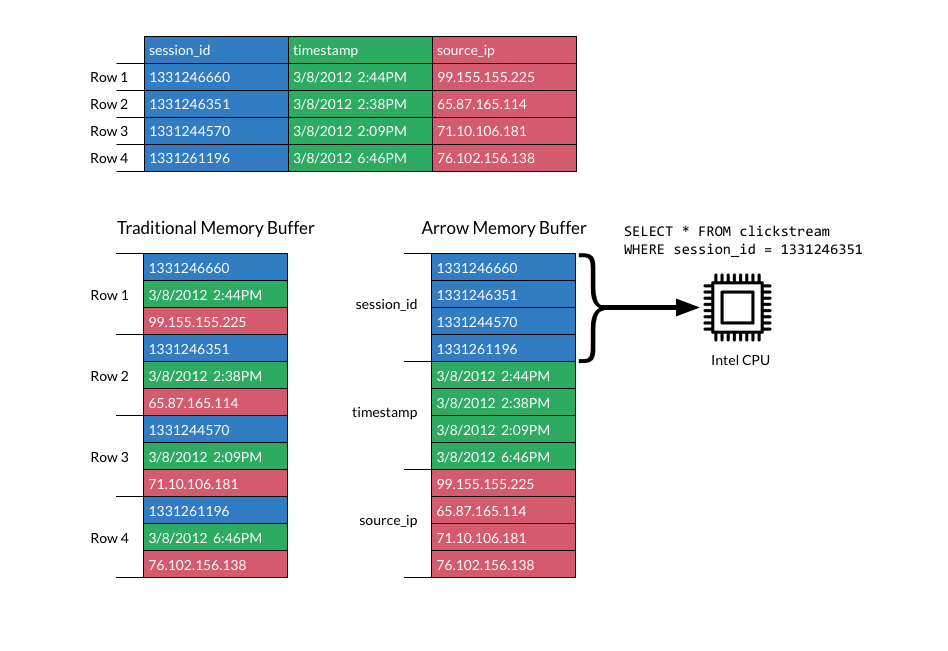

[Columnar format](https://www.microsoft.com/en-us/research/publication/columnar-storage-formats/#:~:text=The%20columnar%20data%20formats%20are,the%20particular%20query%20or%20workload.) is a data storage format that organizes data by column instead of row. As opposed to row-oriented storage, columnar storage can significantly reduce the amount of data fetched from disk by allowing access to only the columns that are relevant for the particular query or workload. With further efficient encoding and compression techniques, the columnar format can drastically reduce storage requirements without sacrificing query performance.

The columnar format also enables [vectorization](https://www.intel.com/content/www/us/en/developer/articles/technical/vectorization-a-key-tool-to-improve-performance-on-modern-cpus.html#:~:text=Vectorization%20is%20the%20process%20of,to%20multiple%20data%20(SIMD).) using the latest SIMD ([Single Instruction, Multiple Data](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data)) operations included in modern processors. In other words, the columnar format is one of many reasons we're able to use `batched = True` in our `Dataset.map()` function, for example.

**Standardization & Arrow Libraries:**

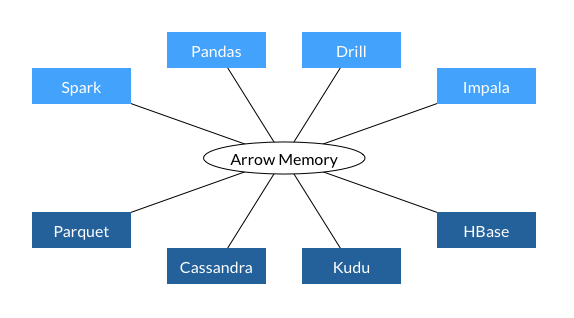



Instead of having to deploy a unique internal data format for every database and every programming language, employing costly serialization and deserialization to move data from one system to another, Arrow's in-memory columnar data format represents an out-of-the-box solution which allows systems that use or support Arrow to transfer data between them at little-to-no cost.

The larger Arrow project contains libraries that enable you to work with data in the Arrow columnar format in a variety of languages. Languages such as C++ and Java contain distinct implementations of the Arrow format, whereas the libraries in languages such as Python are built on top of the C++ library. In particular, Python uses the [`pyarrow`](https://arrow.apache.org/docs/python/index.html) library. These official libraries enable third-party projects to work with Arrow data without having to implement the Arrow columnar format themselves.

**How Does This Apply to 🤗 Datasets?:**

HF Datasets uses Arrow for its [local caching system](https://huggingface.co/docs/datasets/en/about_arrow#memory-mapping). Datasets are backed by an [on-disk cache](https://nordvpn.com/cybersecurity/glossary/disk-cache/#:~:text=Disk%20cache%20is%20a%20temporary,accessed%20information%20is%20readily%20available.), which is memory-mapped for fast lookup; in other words, HF Datasets treats each dataset as a memory-mapped file.

What is memory mapping? In short, we can understand memory mapping as a mapping between RAM and filesystem storage that allows the HF library to access and operate on elements of the dataset without needing to fully load it into memory. This how we are able to utilize MB of RAM for a dataset which is taking up GB of our disk space. If you're interested in learning about the more granular details of memory mapping, [this article](https://www.ibm.com/docs/es/aix/7.2?topic=memory-understanding-mapping) might be of some use.

Another major benefit of memory-mapped files is that such files can be shared across multiple processes, allowing us to parallelize the operations of `Dataset.map()` via the `num_proc` argument without needing to move or copy the dataset, for example.

### **6.1.4: Saving disk space by streaming datasets**

$\textbf{Introduction:}$

**Source:** [Streaming datasets](https://huggingface.co/learn/nlp-course/chapter5/4?fw=pt#streaming-datasets)

To understand the point of streaming datasets, let's return to **The Pile**. If one tried to download this dataset in its entirety, one would need 825 GB of free disk space! To deal with situations where we need to access datasets as large as **The Pile** without comprising our RAM *or* our storage space, HF Datasets provides a streaming feature which allows us to download and access elements on the fly, without needing to download the whole dataset.

To better understand how streamed datasets operate, let's stream in our PubMed Abstracts dataset; see Section 6.1.3 if you haven't yet downloaded the dataset and/or prepared `data_files`. To do this, we simply have to pass `streaming = True` to our `load_dataset()` function:

In [ ]:
pubmed_dataset_streamed = load_dataset(
    "json", data_files=data_files, split="train", streaming=True
)

Instead of returning a familiar `Dataset`, streaming in our dataset has returned an `IterableDataset` object. Fortunately, an [`IterableDataset`](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.IterableDataset) object isn't too different from a `Dataset` object: it's simply a `Dataset` object backed by an iterable. As this description implies, to access the elements of an `IterableDataset` we need to iterate over it:

In [ ]:
# Accessing the first element of our dataset
next(iter(pubmed_dataset_streamed))

{'meta': {'pmid': 11409574, 'language': 'eng'},
 'text': 'Epidemiology of hypoxaemia in children with acute lower respiratory infection.\nTo determine the prevalence of hypoxaemia in children aged under 5 years suffering acute lower respiratory infections (ALRI), the risk factors for hypoxaemia in children under 5 years of age with ALRI, and the association of hypoxaemia with an increased risk of dying in children of the same age. Systematic review of the published literature. Out-patient clinics, emergency departments and hospitalisation wards in 23 health centres from 10 countries. Cohort studies reporting the frequency of hypoxaemia in children under 5 years of age with ALRI, and the association between hypoxaemia and the risk of dying. Prevalence of hypoxaemia measured in children with ARI and relative risks for the association between the severity of illness and the frequency of hypoxaemia, and between hypoxaemia and the risk of dying. Seventeen published studies were found that i

To process the elements of a streamed dataset on the fly, we can use the `IterableDataset.map()` and `IterableDataset.filter()` functions. The process of using this function is exactly the same as using the `Dataset.map()` and `Dataset.filter()` functions.

The real difference between `Dataset` and `IterableDataset` comes down to how we access elements in our streamed dataset.

For example, unlike `Dataset.shuffle()`, `IterableDataset.shuffle()` can only shuffle all the elements in a pre-defined `buffer_size`:

<pre><code class = "python">shuffled_dataset = pubmed_dataset_streamed.shuffle(buffer_size=10_000, seed=42)
next(iter(shuffled_dataset))
</code></pre>

Once an example is accessed, its spot in the buffer is filled with the next example in the corpus; in the case above, this would be the 10,0001st example.

In place of `Dataset.select()`, we can use `IterableDataset.take()` and `IterableDataset.skip()`.

For example, to access the first 5 examples in the PubMed Abstracts dataset:

<pre><code class = "python"><b>Input:</b>
dataset_head = pubmed_dataset_streamed.take(5)
list(dataset_head)
</code></pre>

<pre><code class = "python"> <b>Output:</b>
[{'meta': {'pmid': 11409574, 'language': 'eng'},
  'text': 'Epidemiology of hypoxaemia in children with acute lower respiratory infection ...'},
 {'meta': {'pmid': 11409575, 'language': 'eng'},
  'text': 'Clinical signs of hypoxaemia in children with acute lower respiratory infection: indicators of oxygen therapy ...'},
 {'meta': {'pmid': 11409576, 'language': 'eng'},
  'text': "Hypoxaemia in children with severe pneumonia in Papua New Guinea ..."},
 {'meta': {'pmid': 11409577, 'language': 'eng'},
  'text': 'Oxygen concentrators and cylinders ...'},
 {'meta': {'pmid': 11409578, 'language': 'eng'},
  'text': 'Oxygen supply in rural africa: a personal experience ...'}]
</code></pre>

Similarly, you can use the `IterableDataset.skip()` function to create training and validation splits from a shuffled dataset as follows:

---

*Note: To create training and validation splits when working with `Dataset` objects, you should work with the [`Dataset.train_test_split()`](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.train_test_split) function.*

In [ ]:
# Generate a shuffled dataset
shuffled_dataset = pubmed_dataset_streamed.shuffle(buffer_size = 5000, seed = 50)

# Skip the first 1,000 examples, putting the rest into the training set
train_dataset = shuffled_dataset.skip(1000)

# Take the first 1,000 examples for the validation set
validation_dataset = shuffled_dataset.take(1000)

## **6.2: 🤗 Tokenizers**

$\textbf{Section Introduction:}$

**Source:** [The 🤗 Tokenizers Library](https://huggingface.co/learn/nlp-course/chapter6/1?fw=pt)

This section will be dedicated to everything tokenization. First, we'll start out with an introduction to the WordPiece tokenization algorithm, a popular tokenization algorithm employed in many BERT-based Transformer models, such as DistilBERT. Having developed a basic understanding of WordPiece and tokenization algorithms in general, we'll move on to discussing how the 🤗 Tokenizers library puts these tokenization algorithms into practice via its integration with the 🤗 Datasets and (soon-to-be-introduced) 🤗 Transformers libraries.

### **6.2.1: WordPiece tokenization algorithm**

$\textbf{Introduction:}$

**Source:** [WordPiece Tokenization](https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt#wordpiece-tokenization)

Originally developed by Google for pretraining BERT, the WordPiece tokenization algorithm is a popular tokenization algorithm which has been applied to a variety of BERT-based Transformer models.

We'll spend the first portion of this section explaining WordPiece from a theoretical perspective. In particular, we'll look at the "training algorithm" for generating a tokenized vocabulary using WordPiece before discussing how pre-tokenized words are actually tokenized using the generated vocabulary.

>**Note:** We'll talk about pre-tokenization in more depth in Section 6.2.3, but the basic gist of this process is taking a sentence and (a) converting it to a list of individual words (e.g., for `sentence = 'This is a sentence.'`, `sentence` becomes `['This', 'is', 'a', 'sentence', '.']` and (b) generating offset mappings for each pre-token (e.g., in one type of offset mapping, the offset mapping for `This` would be `(0,3)`, indicating that `sentence[0]` is the first character in `This` while `sentence[3]` indexes the last character).

Unlike with training a deep neural network, tokenization training is a deterministic process. Note that WordPiece is an example of a **[subword tokenization algorithm](https://huggingface.co/docs/transformers/en/tokenizer_summary#subword-tokenization)**; subword tokenization algorithms have been demonstrated to be much more effective than full-word tokenization algorithms, and are in general the industry standard.

Finally, we'll actually code up WordPiece using a small corpus of text & a small final vocabulary size (i.e., not a practical application of WordPiece, but a demonstrative one).

---
*Note: Google technically never open-sourced its implementation of the training algorithm of WordPiece. What follows is an educated guess of the algorithm developed by 🤗 based on published literature; as such, some of the finer details of the algorithm are likely missing in the demonstration to come.*


$\textbf{WordPiece training algorithm:}$

First, WordPiece starts off with a small vocabulary containing all of the model's special tokens and the initial WordPiece alphabet. This alphabet is generated by splitting each word into each of it's characters, appending the appropriate prefix (`##` for BERT) to every character except the first in each word. For example, `word` would be tokenized as such:

<pre>w ##o ##r ##d
</pre>

From here, WordPiece learns certain merge rules in order to build up the WordPiece vocabulary to its desired size (e.g., `##r` and `##d` might be merged into `##rd`, expanding the alphabet above to 5 tokens instead of 4). In particular, WordPiece calculates the following score for each pair of tokens, applying merges at each iteration of the training algorithm to the pair with the highest score:

$$score = \frac{freq\_of\_pair}{freq\_of\_first\_element \; \times \; freq\_of\_second\_element}$$

Instead of just merging the most frequent pairs, WordPiece specifically applies merges to tokens whose individual parts are less frequent in the vocabulary.

Thus the WordPiece training algorithm essentially constitutes taking a large corpus of text, generating the initial vocabulary by adding any special tokens to the initial alphabet generated from all of the words in the large corpus of text, and engaging in the iterative process of generating scores for each pair of vocab words & applying a merge rule to the pair with the highest score until the WordPiece vocabulary has been built up to the desired size. The final generated vocabulary is the output of the WordPiece training algorithm.

$\textbf{WordPiece tokenization algorithm:}$

Having generated our token vocabulary during the training portion of WordPiece, we can now finally tokenize our input text. Starting from the first character of the pre-tokenized word we want to tokenize, WordPiece finds the longest subword that is in the vocabulary, then splits on it.

For example, suppose we are trying to tokenize the word `'bugs'` with the following vocabulary:

<pre>Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu", "hug"]
</pre>

`'b'` is the longest subword starting at the beginning of this word, so WordPiece first tokenizes `'bugs'` as `['b', '##ugs']`. Then `'##u'` is the longest subword starting at the beginning of `'##ugs'` that is in the vocabulary, so we then tokenize this word as `['b', '##u', '##gs']`. Finally, `'##gs'` is the longest subword starting at the beginning of `'##gs'`, so our final tokenization of the word `'bugs'` ends up being the last list: `['b', '##u', '##gs']`.

Before we move on to actually implementing WordPiece, note that if the tokenization "inference" process gets to a stage where it’s not possible to find a subword in the vocabulary, then WordPiece tokenizes the whole word as unknown. For example, `'bum'` would get tokenized as `['[UNK]']` given the above vocabulary; even though we can start with `'b'` and `'##u'`, `'##m'` is not in our vocabulary.

$\textbf{Implementing WordPiece:}$

In this section, we'll actually implement WordPiece. First, let's start off with our corpus of text:

In [ ]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

Now, let's first compute the frequency of each word in this corpus as we apply the pre-tokenization process. Since WordPiece is popular in BERT-based Transformer models, we'll be using HF Transformers' [`bert-based-cased`](https://huggingface.co/google-bert/bert-base-cased) model for our pre-tokenization.

In [ ]:
from transformers import AutoTokenizer
from collections import defaultdict

# Loading in our tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Computing the frequencies of each word (& character) in our corpus of text
word_freqs = defaultdict(int)
for text in corpus:
  # Pre-tokenize each sentence
  words = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)

  new_words = [word for word, offset in words]
  for word in new_words:
    word_freqs[word] += 1

# Final result
word_freqs

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


defaultdict(int,
            {'This': 3,
             'is': 2,
             'the': 1,
             'Hugging': 1,
             'Face': 1,
             'Course': 1,
             '.': 4,
             'chapter': 1,
             'about': 1,
             'tokenization': 1,
             'section': 1,
             'shows': 1,
             'several': 1,
             'tokenizer': 1,
             'algorithms': 1,
             'Hopefully': 1,
             ',': 1,
             'you': 1,
             'will': 1,
             'be': 1,
             'able': 1,
             'to': 1,
             'understand': 1,
             'how': 1,
             'they': 1,
             'are': 1,
             'trained': 1,
             'and': 1,
             'generate': 1,
             'tokens': 1})

Now, let's generate our initial vocbaulary. Our initial vocabulary is composed of our initial alphabet as well as all of the special tokens utilized by the BERT Transformer model.

In [ ]:
alphabet = []
for word in word_freqs.keys():
  # Take the first character of each word in word_freqs.keys()
  if word[0] not in alphabet:
    alphabet.append(word[0])

  # Iterate through the rest of the characters in each word contained in word_freqs.keys() to append
  # the necessary WordPiece prefix
  for letter in word[1:]:
    if f"##{letter}" not in alphabet:
      alphabet.append(f"##{letter}")

alphabet.sort()

vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']


Next, we split each word:

In [ ]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

splits

{'This': ['T', '##h', '##i', '##s'],
 'is': ['i', '##s'],
 'the': ['t', '##h', '##e'],
 'Hugging': ['H', '##u', '##g', '##g', '##i', '##n', '##g'],
 'Face': ['F', '##a', '##c', '##e'],
 'Course': ['C', '##o', '##u', '##r', '##s', '##e'],
 '.': ['.'],
 'chapter': ['c', '##h', '##a', '##p', '##t', '##e', '##r'],
 'about': ['a', '##b', '##o', '##u', '##t'],
 'tokenization': ['t',
  '##o',
  '##k',
  '##e',
  '##n',
  '##i',
  '##z',
  '##a',
  '##t',
  '##i',
  '##o',
  '##n'],
 'section': ['s', '##e', '##c', '##t', '##i', '##o', '##n'],
 'shows': ['s', '##h', '##o', '##w', '##s'],
 'several': ['s', '##e', '##v', '##e', '##r', '##a', '##l'],
 'tokenizer': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##e', '##r'],
 'algorithms': ['a',
  '##l',
  '##g',
  '##o',
  '##r',
  '##i',
  '##t',
  '##h',
  '##m',
  '##s'],
 'Hopefully': ['H', '##o', '##p', '##e', '##f', '##u', '##l', '##l', '##y'],
 ',': [','],
 'you': ['y', '##o', '##u'],
 'will': ['w', '##i', '##l', '##l'],
 'be': ['b', '##e

Now, we're ready for training. Below, we'll write two functions:

1.   `compute_pair_scores()` can be used to compute the score for each pair of subwords given the `splits` dictionary we generated above.
2.   `merge_pair()` can be used to apply the appropriate merge rule to two subwords given the two subwords and the `splits` dictionary.

In [ ]:
def compute_pair_scores(splits):
  letter_freqs = defaultdict(int)
  pair_freqs = defaultdict(int)

  for word, freq in word_freqs.items():
    split = splits[word]

    # If the word only contains a single character, we only need to update letter_freqs:
    if len(split) == 1:
        letter_freqs[split[0]] += freq
        continue

    # Otherwise, we'll iterate through each pair of subsequent characters to update both pair_freqs & letter_freqs:
    for i in range(len(split) - 1):
        pair = (split[i], split[i + 1])
        letter_freqs[split[i]] += freq
        pair_freqs[pair] += freq
    letter_freqs[split[-1]] += freq     # The for loop above doesn't capture the letter frequency of the last character in each multi-character word.

  # Compute WordPiece algorithm scores
  scores = {
      pair : freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
      for pair, freq in pair_freqs.items()
  }

  return scores

def merge_pair(a, b, splits):
  for word in word_freqs:
    split = splits[word]

    # No merge rule can be applied to a single-character word
    if len(split) == 1:
      continue

    # Iterate through every multi-character word
    i = 0
    while i < len(split) - 1:
      if split[i] == a and split[i + 1] == b:
        merge = a + b[2:] if b.startswith("##") else a + b
        split = split[:i] + [merge] + split[i + 2:]     # Replace the subwords a & b with the merged word merge in the relevant key of our splits dictionary
      else:
        i += 1
    splits[word] = split
  return splits

Now, we're ready to write our tokenization training loop. We're going to aim for a vocabulary size of 70:

In [ ]:
# Training algorithm
vocab_size = 70
while len(vocab) < vocab_size:

  # Compute each score for each split in our splits dictionary & capture the pair ("best_pair") with the highest associated score ("max_score")
  scores = compute_pair_scores(splits)
  best_pair, max_score = "", None
  for pair, score in scores.items():
    if max_score is None or max_score < score:
      best_pair = pair
      max_score = score

  # Update our splits dictionary
  splits = merge_pair(*best_pair, splits)

  # We don't return the new token in our merge_pair() function, so we extract it from best_pair here:
  new_token = (
      best_pair[0] + best_pair[1][2:]
      if best_pair[1].startswith("##")
      else best_pair[0] + best_pair[1]
  )

  vocab.append(new_token)

# Final result
print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', '##fu', 'Fa', 'Fac', '##ct', '##ful', '##full', '##fully', 'Th', 'ch', '##hm', 'cha', 'chap', 'chapt', '##thm', 'Hu', 'Hug', 'Hugg', 'sh', 'th', 'is', '##thms', '##za', '##zat', '##ut', '##ta']


Having finished and applied our WordPiece training algorithm, we can now write up our WordPiece tokenization algorithm.

In particular, we'll write up 2 functions:

1.   Given a word as input (and, implicitly, our vocabulary in `vocab`), `encode_word()` will tokenize this word.
2.   Given an input text (e.g., a sentence), `tokenize_text()` will tokenize the input.



In [ ]:
# Functions
def encode_word(word):
  tokens = []
  while len(word) > 0:
    i = len(word)
    while i > 0 and word[:i] not in vocab:
      i -= 1
    if i == 0:
      return ["[UNK]"]

    tokens.append(word[:i])
    word = word[i:]
    if len(word) > 0:
      word = f"##{word}"

  return tokens

def tokenize_text(text):
  pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
  pre_tokenized_text = [word for word, offset in pre_tokenize_result]     # Remove offsets from our pre-tokenized text, since we don't require them
  encoded_words = [encode_word(word) for word in pre_tokenized_text]

  return sum(encoded_words, [])

# Let's try out our WordPiece tokenization algorithm on an example piece of text:
tokenize_text("This is the Hugging Face course!")

['Th',
 '##i',
 '##s',
 'is',
 'th',
 '##e',
 'Hugg',
 '##i',
 '##n',
 '##g',
 'Fac',
 '##e',
 'c',
 '##o',
 '##u',
 '##r',
 '##s',
 '##e',
 '[UNK]']

### **6.2.2: Understanding fast tokenizers**

$\textbf{Introduction:}$

**Source:** [Fast tokenizers’ special powers](https://huggingface.co/learn/nlp-course/chapter6/3?fw=pt)

🤗 provides access to two types of tokenizers: "slow" tokenizers -- tokenizers written in Python in the HF Transformers library -- and "fast" tokenizers -- tokenizers written in Rust which are provided through the HF Tokenizers library.

The performance difference between "slow" and "fast" tokenizers is oftentimes substantial. For example, going back to the Drug Review Dataset introduced in Section 6.1.2, HF researchers recorded the following times taken when tokenizing the entire aforementioned dataset:

\begin{array}{ccc}
  & \textbf{Fast tokenizer} & \textbf{Slow tokenizer} \\
  \hline
  \scriptsize{batched = True} & \small{10.8s} & \small{4min \; 41s} \\
  \scriptsize{batched = False} & \small{59.2s} & \small{5min \; 3s}
\end{array}

Beyond speed benefits (which often only come into play when tokenizing or otherwise performing operations on tons of text in parallel), "fast" tokenizers provide a variety of additional functionality which proves useful when pre-processing datasets and training LLMs for various NLP tasks.

In this section, we'll do a brief tour of `BatchEncoding` objects and the variety of functionality that "fast" tokenizers backed by the 🤗 Tokenizers library provides.

$\textbf{What are BatchEncoding objects?:}$

Instead of a simple Python dictionary object, the output of a "fast" tokenizer is a `BatchEncoding` object. A `BatchEncoding` object is a subclass of a dictionary which provides access to a variety of additional methods which "fast" tokenizers can take advantage of; you can find an exhaustive list of these various methods [here](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/tokenizer#transformers.BatchEncoding).

Beyond parallelization, the key functionality of fast tokenizers is their generated *offset mappings* -- mappings between the original span of text and the tokens generated from them. Going beyond the basic example given in Section 6.2.1, "offset mappings" refers to a whole class of mappings, including:

*   mappings from each word to the token it generated, and vice versa; or
*   mappings from each character of the input text to the token it's inside, and vice versa.

Now, we'll take some time to look at a brief example in order to explore all of these different mappings and methods accessible to "fast" tokenizers.

In [ ]:
from transformers import AutoTokenizer

# Instantiating the tokenizer used in the bert-base-cased model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Example text
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."

# Generating tokens
encoding = tokenizer(example)

# Outputs
print(encoding)
print(type(encoding))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'input_ids': [101, 1422, 1271, 1110, 156, 7777, 2497, 1394, 1105, 146, 1250, 1120, 20164, 10932, 10289, 1107, 6010, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
<class 'transformers.tokenization_utils_base.BatchEncoding'>


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


First, and foremost, let's explore the output of our tokenizer. We see the following outputs generated:

1.   `input_ids`: These are the actual tokens generated from the input text provided to the tokenizer.
2.   `token_type_ids`: These IDs are only relevant for certain NLP tasks. For example, if one wanted to supervised fine-tune a model for generative question-answering, the input sequences provided to the model's tokenizer would contain both the question and desired answer. In this case, the `token_type_ids` would be used to differentiate between tokens belonging to the question text input (e.g., `0`) and the answer text input (e.g., `1`).
3.   `attention_mask`: As the name suggests, the value associated with this `BatchEncoding` key is the attention mask applied to the provided input sequence. Our model will attend to tokens whose `attention_mask` value is `1`, whereas our model won't attend to tokens assigned a value of `0`.

Note that the following output format isn't necessarily standard (excluding the `input_ids`, which are always generated). Certain models expect more or less ouputs from the tokenizer, so make sure that when you are instantiating a tokenizer using `AutoTokenizer.from_pretrained()`, the checkpoint you provide as input is the same as the checkpoint used to generate a model using `AutoModel.from_pretrained()` (we'll cover the latter function in Section 6.3).

Second, notice that our encodings are a `BatchEncoding` object, not a regular `dict` object (although the representations of both types of objects are quite similar).






As a quick note, it's always best to check the type of your instantiated tokenizer before attempting to acess any methods only available to "fast" tokenizers. In the case of the code above, we could check the type of the tokenizer by checking the tokenizer directly:

<pre><code class="python"><b>Input:</b>
tokenizer.is_fast

<b>Output:</b>
True
</code></pre>

or by checking the tokenizer's output, as follows:

<pre><code class="python"><b>Input:</b>
encoding.is_fast

<b>Output:</b>
True
</code></pre>

$\textbf{Important Methods of "Fast" Tokenizers}$

Now, let's explore some of the various methods accessible for use with a "fast" tokenizer. We list descriptions of the important methods in this text box, and then show their outputs below:

*   `tokens()`: This method returns the list of tokens at a given batch index; if only a single batch is provided, you don't need to specify any batch index. The list of tokens generated are the sub-parts of the input string generated after word/subword splitting but before conversion to integer indices (e.g., the final output of the WordPiece tokenization algorithm deployed in Section 6.2.1).

*   `word_ids()`: A list indicating the word corresponding to each token. Special tokens added by the tokenizer are mapped to `None` while other tokens are mapped to the index of their corresponding word; in relevant cases, several tokens will be mapped to the same word index.

*   `sequence_ids()`: A method which can be used to map a token to the sentence it came from. In our case, the `token_type_ids` returned by the tokenizer provides the same information.

*   `word_to_chars()`: Give as input `batch_index` (if necessary) and `word_index`. To understand what `word_index` is, imagine for the sake of simplicitly that you've provided only a single input sequence to the tokenizer. Now, imagine generating a list from this input sequence of text where each list entry is a single word (or punctuation mark) from this input text; `word_index` is an integer you could use to index a single entry from this list. The output to this method is a `CharSpan` `NamedTuple` object of format: `(<index_of_first_character_in_original_string>, <index_of_last_character_in_original_string>)`. See the example below for further clarification.

*   `token_to_chars()`: Given as input `batch_index` (if necessary) and `token_index` (i.e., given the list generated by the `tokens()` method, `token_index` as in `tokens_list[token_index]`), this method returns the span of characters in the original string, or None, if the token doesn’t correspond to any characters in the original string. In particular, the output is a `CharSpan` object of the same `(<start>, <end>)` format as the output to the `word_to_chars()` method.

*   `char_to_word()`: Given as input `batch_index` (if necessary) and `char_index` (the index of a character in the original string), this method returns the index or indices of the associated encoded token(s). For example, suppose you provide as input the index associated with the character 'y' as in 'Sylvian' in the original string (as is done below). Now, pre-tokenize your string via the `backend_tokenizer.pre_tokenizer.pre_tokenize_str()` method; if necessary, remove any offsets or miscellaneous information returned so that you only have a list of strings. If you index this list by the integer returned by `char_to_word()`, you'll get the word 'Sylvian' (and hence "character to word").

*   `char_to_token()`: Give as input `batch_index` (if necessary) and `char_index` (the index of a character in the original string). To understand the output, entertain the following example. Suppose you give as input the index associated with the character 'v' as in 'Sylvian' in the original string (as is done below). If you take the integer output and use it to index the list generated by the `tokens()` method, you'll get the token that character whose index you provided to this method is associated with.


In [ ]:
# tokens()
print("\033[1mtokens():\033[0m ", encoding.tokens())

# word_ids()
print("\033[1mword_ids():\033[0m ", encoding.word_ids())

# sequence_ids()
print("\033[1msequence_ids():\033[0m ", encoding.sequence_ids())

# word_to_chars()
start, end = encoding.word_to_chars(3)
print("\033[1mword_to_chars():\033[0m ", example[start:end])

# token_to_chars()
start, end = encoding.token_to_chars(10)
print("\033[1mtoken_to_chars():\033[0m ", example[start:end])

# char_to_word()
print("\033[1mchar_to_word():\033[0m \n \t \033[1mCharacter:\033[0m ", example[12], "\n \t (Not in output:) as in 'Sylvian'. \n\n \t \033[1mIndex:\033[0m ", encoding.char_to_word(12))

pre_tokenization = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(example)
pre_tokenization_modified = [input[0] for input in pre_tokenization]

print("\n\t \033[1mpre_tokenization (pre-tokenized example):\n\t\033[0m", pre_tokenization)
print("\n\t \033[1mpre_tokenization_modified:\n\t\033[0m", pre_tokenization_modified)
print("\n\t \033[1mIndexing pre_tokenization_modified By Output:\033[0m ", pre_tokenization_modified[encoding.char_to_word(12)])

# char_to_token()
print("\033[1mchar_to_token():\033[0m \n \t \033[1mCharacter:\033[0m ", example[14], "\n\t (Not in output:) as in 'Sylvian'. \n\n\t \033[1mOutput:\033[0m", encoding.char_to_token(14),"\n\n\t \033[1mIndexing encoding.tokens() By Output:\033[0m ", encoding.tokens()[encoding.char_to_token(14)])

tokens():  ['[CLS]', 'My', 'name', 'is', 'S', '##yl', '##va', '##in', 'and', 'I', 'work', 'at', 'Hu', '##gging', 'Face', 'in', 'Brooklyn', '.', '[SEP]']
word_ids():  [None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]
sequence_ids():  [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None]
word_to_chars():  Sylvain
token_to_chars():  work
char_to_word(): 
 	 Character:  y 
 	 (Not in output:) as in 'Sylvian'. 

 	 Index:  3

	 pre_tokenization (pre-tokenized example):
	 [('My', (0, 2)), ('name', (3, 7)), ('is', (8, 10)), ('Sylvain', (11, 18)), ('and', (19, 22)), ('I', (23, 24)), ('work', (25, 29)), ('at', (30, 32)), ('Hugging', (33, 40)), ('Face', (41, 45)), ('in', (46, 48)), ('Brooklyn', (49, 57)), ('.', (57, 58))]

	 pre_tokenization_modified:
	 ['My', 'name', 'is', 'Sylvain', 'and', 'I', 'work', 'at', 'Hugging', 'Face', 'in', 'Brooklyn', '.']

	 Indexing pre_tokenization_modified By Output:  Sylvain
char_to_token(): 
 	 Character:  v 
	 (Not in output:) as in 

### **6.2.3: Walk-through of tokenization process**

$\textbf{Introduction:}$

**Source:** [Building a tokenizer, block by block](https://huggingface.co/learn/nlp-course/chapter6/8?fw=pt)

Overall, the entire process of tokenization is composed of the following steps:

*   **Normalization:** During this step, we conduct any necessary cleanup, including removing spaces or accents, Unicode normalization, and the such. This step varies depending upon what type of input the particular model you're working with expects. We've haven't mentioned this process up until now, but as you can see, it's pretty self-explanatory.
*   **Pre-Tokenization:** Splitting the input into a list of words (and punctuation marks).
*   **Tokenization:** Running your pre-tokens through the (already-trained) tokenizer to generate batches of sequences of tokens.
*   **Post-Processing:** This process covers a variety of things, namely: adding special tokens to the tokenizer, and generating attention masks and token type IDs. We've seen bits of this step in what we've covered so far.

In this section, we're going to build up a tokenizer from scratch. This section will work as a good review of what we've discussed so far, and function as a good place to mention any of the finer details surrounding the tokenization process that we've neglected up to this point.

In order to construct our new tokenizer, we're going to use HF's `Tokenizer` class. This class contains the following submodules which we will use to build our new tokenizer:

*   `normalizers` => Contains all possible types of `Normalizers` you can use. A complete list of all `Normalizers` can be found [here](https://huggingface.co/docs/tokenizers/api/normalizers).
*   `pre_tokenizers` => Contains all the possible types of `PreTokenizer` you can use. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/pre-tokenizers).
*   `models` => Contains the various types of models you can use -- namely, `WordPiece`, which we'll be using. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/models).
*   `trainers` => Contains all the different types of `Trainer` you can use to train your model on a corpus. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/trainers).
*   `post_processors` => Contains the various types of `PostProcessor` you can use. A complete list can be found [here](https://huggingface.co/docs/tokenizers/api/post-processors).
*   `decoders` => Contains the various types of `Decoder` you can use to decode the outputs of tokenization (convert a list/array/tensor of integer token indices into words). A complete list can be found [here](https://huggingface.co/learn/nlp-course/chapter6/8?fw=pt).



$\textbf{Generating our Corpus of Text:}$

In order to train our tokenizer, we'll be utilizing the [WikiText-2](https://huggingface.co/datasets/Salesforce/wikitext) dataset. In order to work with this dataset, we need to first instantiate the dataset before writing a [generator](https://www.programiz.com/python-programming/generator) function which can be used to iterate through the entire dataset; in particular, our generator will yield 1000 text sequences at a time. For future reference, HF Tokenizers tokenizers can be trained on text files directly; still, the generator approach will for our purposes be easier.

In [ ]:
from datasets import load_dataset

# Load in dataset
dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split = "train")

# Generator
def get_training_corpus():
  for i in range(0, len(dataset), 1000):
    yield dataset[i : i + 1000]["text"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

$\textbf{Building a WordPiece tokenizer from scratch:}$

In line with the tokenization algorithm we demonstrated back in Section 6.2.1, here we practically implement a WordPiece tokenizer from scratch. In particular, we'll be building up the WordPiece tokenizer utilized in the BERT Transformer model.

Our general process will involve instantiating a `Tokenizer` object with a `model`, before setting its `normalizer`, `pre_tokenizer`, `post_processor`, and `decoder` attributes to the desired values.

---

*Note: When we instantiate our `Tokenizer` object with our `model`, we need to specify the `unk_token` so the model knows what to return when it encounters characters it hasn’t seen before.*

*Some additional arguments we could've passed to the model include:*
*   *`vocab` - Pass in the vocabulary of our model. Since we’re going to train the model, we don’t need to set this. For future reference, you can call the `get_vocabulary()` method on a 🤗 Tokenizers tokenizer (such as one instantiated via the `load_pretrained()` method) to extract a tokenizer's vocabulary.*
*   *`max_input_chars_per_word` - This argument can be used to specify a maximum length for each word; words longer than this value are split.*



In [ ]:
# Imports
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [ ]:
# Instantiating Tokenizer object with model
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

Now, let's replicate a BERT tokenizer (in particular, the tokenizer utilized in the training of the `bert-base-uncased` model). Composing multiple normalizers via `normalizers.Sequence()`, we'll pass in the following normalizers: `NFD`, `Lowercase`, and `StripAccents`.

For reference, `normalizers.NFD()` is a NFD Unicode normalizer; without this normalizer, `normalizers.StripAccents()` won’t be able to properly recognize the accented characters.

In [ ]:
# Adding a normalizer module to our tokenizer
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

# Testing our normalizer by calling the normalize_str() method of the normalizer module:
print("\033[1mTest String Output:\033[0m ", tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

Test String Output:  hello how are u?


Next, we build our BERT `pre_tokenizer` module from scratch. We use the `pre_tokenizer.WhitespaceSplit()` and `pre_tokenizer.Punctuation()` objects in sequence to do so.

In [ ]:
# Adding a pre-tokenizer module to our tokenizer
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
tokenizer.pre_tokenizer = pre_tokenizer

# Test our pre-tokenizer by calling the pre_tokenize_str() method of our tokenizer's pre_tokenizer module:
print("\033[1mTest String Output:\033[0m ", tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")
)

Test String Output:  [('Let', (0, 3)), ("'", (3, 4)), ('s', (4, 5)), ('test', (6, 10)), ('my', (11, 13)), ('pre', (14, 17)), ('-', (17, 18)), ('tokenizer', (18, 27)), ('.', (27, 28))]


Before we can train our tokenizer, we need to instantiate our tokenization trainer. In our particular case, we will be using `WordPieceTrainer`. The main thing to remember when instantiating a HF Tokenizers `Trainer` is to pass in all the special tokens you intend to use -- otherwise it won’t add them to the vocabulary, since they are not in the training corpus.

---

*Note: Beyond `vocab_size` and `special_tokens`, we could have also passed in the following arguments:*
*   *`min_frequency` - Set the minimum number of times a token must appear to be included in the vocabulary.*
*   *`continuing_subword_prefix` - If we want to utilize something different from `##`, we can set the desired string here.*



In [ ]:
# Loading in our tokenizer's Trainer
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

With our `Trainer` object instantiated, we can train our `tokenizer` by simply calling the `train_from_iterator()` method, passing in our generator function as well as our `Trainer` object:

In [ ]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

If we wanted to, we could now test our tokenizer by calling its `encode()` method. For example:

<pre><code class="python"><b>Input: </b>
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)
</code></pre>

<pre><code class="python"><b>Output: </b>
['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.']
</code></pre>

Note that the `encoding` we've generated contains all the necessary outputs of the tokenizer in its various attributes: `ids`, `type_ids`, `tokens`, `offsets`, `attention_mask`, `special_token_masks`, and `overflowing` (`special_token_masks` is self-explanatory, and `overflowing` is something we'll discuss later).

Now, we'll add a `post_processor` module to our tokenizer. In order to create our post-processor, we need to use a `TemplateProcessor` object.

For our `TemplateProcessor` object, we need to specify how to treat a single sentence and a pair of sentences. For our post-processor, we want to add the `[CLS]` token at the beginning and `[SEP]` token at the end of each sentence, or after each sentence (in the case of pairs of sentences being included in a single input sequence). To do this, note the following:
*   The first (or single) sentence is represented by `$A`, while the second sentence is represetned by `$B`.
*   For each of thes special tokens and sentences, we also specify the corresponding token type ID after a colon.



In [ ]:
# Get the token IDs associated with our [CLS] and [SEP] tokens
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")

# Add a post_processor module to our tokenizer
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

Now, let's add a `decoder` module to our tokenizer.

In [ ]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

We could stop here. If you wanted to do so, you can save your tokenizer in a single JSON file as follows:

<pre><code class="python">tokenizer.save("tokenizer.json")
</code></pre>

Now, you can reload that file in a `Tokenizer` object with the `from_file()` method:

<pre><code class="python">new_tokenizer = Tokenizer.from_file("tokenizer.json")
</code></pre>

If you want to be able to use this tokenizer in 🤗 Transformers (the topic of our next section), our actual last step will be wrapping our tokenizer in a `PreTrainedTokenizerFast`. To do so, we can either pass the tokenizer we built as a `tokenizer_object` or pass the tokenizer file we saved as `tokenizer_file`. The key thing to remember is that we have to manually set all the special tokens.

In [ ]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # tokenizer_file="tokenizer.json",      # If you want to pass in a tokenizer from a file
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


And that's it! Now, you can use your tokenizer like any other 🤗 Transformers tokenizer. If you want, you can save this tokenizer using the [`save_pretrained()`](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/model#transformers.PreTrainedModel.save_pretrained) method.

## **6.3: 🤗 Transformers: Behind the Pipeline API**

$\textbf{Section Introduction: }$

**Source:** [Transformers, what can they do?](https://huggingface.co/learn/nlp-course/chapter1/3?fw=pt)

While the 🤗 Datasets and 🤗 Tokenizers are going to be crucial libraries for preparing your datasets and input text for any variety of NLP tasks, the 🤗 Transformers library will be your main go-to library when working with Transformers and LLMs. HF hosts over [900,000 models](https://huggingface.co/docs/hub/en/index) (including Transformer-based models, CNNs, RNNs, etc.), which are accessible via the [Model Hub](https://huggingface.co/models). In order to utilize and create your own 🤗 Transformers models, you will be using the 🤗 Transformers library.

The most basic object in the 🤗 Transformers library is the `pipeline()` function. This function connects a model with its necessary preprocessing and postprocessing steps, allowing you to directly input any text & receive an intelligble answer. For example, let's use the `pipeline()` function for the following simple extractive QA task:

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'score': 0.6949766278266907, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

You can customize the basic `pipeline()` function in a variety of ways; for example, you can pass in a string to the `model` argument to specify (in the above case) a specific NLP model fine-tuned for QA tasks, or pass a Boolean value to `use_fast` to specify whether or not you want to use a "fast" tokenizer. A complete documentation can be found [here](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/pipelines#transformers.pipeline) (scroll to the bottom of the linked-to section).

In this section, we're going to be looking at how to use the 🤗 Transformers library in order to essentially re-create the results we can get from the baseline `pipeline()` function. In our progress towards this task we'll learn how to integrate the 🤗 Datasets and 🤗 Tokenizers libraries with the 🤗 Transformers library in order to utilize 🤗's NLP capabilities to its fullest extent.

### **6.3.1: Using models with 🤗 Transformers**

$\textbf{Introduction: }$

**Source:** [Models](https://huggingface.co/learn/nlp-course/chapter2/3?fw=pt)

In this section, we're going to look at the variety of different methods available to us for loading in and saving our HF models.

In general, when loading in 🤗 models you'll want to utilize the `AutoModel` class. In particular, you'll oftentimes be using a particular "variation"/version of this class depending upon the particular task you are trying to instantiate a model for (e.g., `AutoModelForQuestionAnswering` if you want to load in a NLP model trained for QA tasks); these particular variations essentially amount to adding different "heads"/re-configuring the final layer of the model depending upon what task you want to train the model for (e.g., a binary sentiment analysis model only requires that the final layer of the model contain two logit-producing neurons).  

The `AutoModel` class and all of its relatives are simple wrappers over the wide variety of pre-trained models available in the library. It’s a clever wrapper as it can automatically guess the appropriate model architecture configuration for your checkpoint, and then instantiates a model with this architecture; all you'll have to do is pass in a string specifying the particular model checkpoint you want (e.g., `bert-base-uncased`).

The important thing to understand about the `AutoModel` class is that it's just a shortcut command. Behind the scenes, the library has one model class per combination of architecture plus class/"variation". For example, if you call the `AutoModelForSequenceClassification` class using the model `"distilbert-base-uncased-finetuned-sst-2-english"`, this class will actually instantiate a `DistilBertModel` class -- in particular, the `DistilBertForSequenceClassification` class.

$\textbf{Loading in a Model: }$

Now, let's initialize a BERT model. To do so, we must instantiate its configuration before passing this configuration in as a model argument into the appropriate model class (in this case, we want `BertConfig` and `BertModel`). Using this approach, we automatically randomly initialize the weight and bias neurons of our model architecture.

In [ ]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()
print(config)

# Building the model from the config
model = BertModel(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In order to load in a pre-trained BERT model, we will instead want to use the `from_pretrained()` method. Instead of passing in a `BertConfig` object, we'll instead pass in the `bert-base-cased` identifier.

By utilizing the `from_pretrained()` method, we've now loaded a BERT model with the weights associated with the `bert-base-cased` model checkpoint. As a pre-trained model, we can use this model for inference purposes for the tasks it was trained on, or fine-tune this model for a separate task. By training with pretrained weights rather than from scratch, we can quickly achieve good results without significant data or computational cost. You can find out more about the specifics of the `bert-base-cased` model checkpoint by reading its [model card](https://huggingface.co/google-bert/bert-base-cased).

Note that the identifier used to load the model can be the identifier of any model on the Model Hub, as long as it is compatible with the BERT architecture. To find a complete list of all such models, see [here](https://huggingface.co/models?other=bert&sort=trending).

---

*Note: The URL linked to "here" is as follows:*

<pre>
https://huggingface.co/models?other=bert&sort=trending
</pre>

*To search for all models that are compatible with, say, the DistilBERT architecture, modify the above url as follows:*

<pre>
https://huggingface.co/models?<b>other=distilbert</b>&sort=trending
</pre>

*To see a complete list of all models you could modify the above "other" tag with, go to the [🤗 Transformers documentation](https://huggingface.co/docs/transformers/index) and search under "Models" > "Text Models".*

In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

$\textbf{Saving Our Model: }$

In order to save our above model, we simply use the `save_pretrained()` method in a manner such as the following:

<pre><code>model.save_pretrained("directory_on_my_computer")
</code></pre>

Doing so will save the following files into the specified directory:

<pre>(1) config.json
(2) model.safetensors</pre>

The *config.json* file will include all attributes necessary to build the model architecture. This file will also contain some additional metadata, such as where the checkpoint originated and what 🤗 Transformers version you were using when you last saved the checkpoint

The *model.safetensors* file is our state dict -- that is, it contains all of our model weights. If you're interested in learning more about the Safetensors file format, you can start reading up about it [here](https://huggingface.co/docs/safetensors/en/index).

### **6.3.2: Using tokenizers with 🤗 Transformers**

$\textbf{Introduction: }$

**Source:** [Tokenizers](https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt#tokenizers)

In this section, we'll be looking at how to work with tokenizers in the 🤗 Transformers library.

We've already worked with tokenizers extensively in Section 6.2 (in fact, Section 6.2.3 was all about building a tokenizer from scratch which could *also* be integrated with the 🤗 Transformers library). The main difference between Section 6.2 and this section is that while we only covered methods available to "fast" tokenizers in Section 6.2, the methods covered here are available to both "fast" *and* "slow" tokenizers. Most of time you are (and should be) working with "fast" tokenizers; still, it's useful to know the following general methods.

$\textbf{Loading and Saving a Tokenizer: }$

We can easily load and save our tokenizers with the same two methods we use for our models: `from_pretrained()` and `save_pretrained()`. When saving our tokenizer, we're essentially saving both the algorithm used (similar to the *architecture* of a model) as well as the vocabulary (similar to the *weights* of a model).

Let's load in below a BERT tokenizer trained with the same checkpoint as the BERT model we looked at the in the previous section. Similar to the `AutoModel` and `BertModel` classes, there are the `AutoTokenizer` and `BertTokenizer` classes, respectively. Unlike the former classes, though, there is relatively less variety in the number of tokenizer classes available; whereas you might be inclined to use `AutoModelForSequenceClassification` or `AutoModelForQuestionAnswering` depending upon which task you are trying to fine-tune a pre-trained model on, you generally just use the `AutoTokenizer` (or, as in our case, `BertTokenizer`) class.

In [ ]:
from transformers import AutoTokenizer

# Loading our tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenizer inference on an example input sequence
tokenizer("Using a Transformer network is simple")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

To save our tokenizer, we'd run something like the following:

<pre><code>tokenizer.save_pretrained("directory_on_my_computer")
</code></pre>

$\textbf{Common Tokenization Methods Available in the HF Transformers Library:}$

In general, you'll simply be calling the tokenizer directly on your inputs. Still, we dedicate this section to a brief review of some common tokenization methods applicable to 🤗 Transformers-supported tokenizers which you may encounter outside of this notebook (and, in fact, have already encountered in previous sections).

Generally speaking, the *encoding* process (i.e., the process of encoding input text into a sequence of numbers) is two-fold. First, you translate your input sequence into a list of tokens via the tokenizer's `tokenize()` method. Finally, you'll convert your list of tokens into a sequence of numbers/input IDs via the tokenizer's `convert_tokens_to_ids()` method. Let's quickly try it out:

In [ ]:
from transformers import AutoTokenizer

# Load in the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenize an input sequence
sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)
print("\033[1mTokens:\033[0m ", tokens)

# Convert our tokens to numbers/input IDs
ids = tokenizer.convert_tokens_to_ids(tokens)
print("\033[1mNumber IDs:\033[0m ", ids)
  # These IDs are currently stored in a list. You'll want to convert this list of IDs into a torch.Tensor in order to
  # actually work with them.

Tokens:  ['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']
Number IDs:  [7993, 170, 13809, 23763, 2443, 1110, 3014]


In order to decode a sequence of vocabulary indices back into the original string, we can simply call the tokenizer's `decode()` method.

Note that the `decode()` method not only converts the indices back to tokens, but also groups together the tokens that were part of the same words to produce a readable sentence. This behavior will be useful when we use models that predict new text.

Let's look at a quick example to wrap up this section:

In [ ]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


### **6.3.3: Additional details: padding, attention masks, and more**

$\textbf{Introduction: }$

**Sources:**
1.   [Handling multiple sequences
](https://huggingface.co/learn/nlp-course/chapter2/5?fw=pt#handling-multiple-sequences)
2.   [Putting it all together](https://huggingface.co/learn/nlp-course/chapter2/6?fw=pt)
3.   [Padding and truncation](https://huggingface.co/docs/transformers/en/pad_truncation#padding-and-truncation)

In this section, we're going to cover some additional details related to utilizing models and tokenizers within the 🤗 Transformers library. In particular, we'll cover the following topics:

*   Batching  
*   Padding
*   Attention Masks
*   Truncation

$\textbf{Batching: }$

Suppose you run the following code:

<pre><code><b>Input: </b>
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
input_ids = torch.tensor(tokenizer.convert_tokens_to_ids(tokens))

model(input_ids)   # This line will fail
</code></pre>

You'll end up getting the following `IndexError`.

<pre><code><b>Output: </b>
IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)
</code></pre>

Why? 🤗 Transformers models expect multiple sentences by default. This doesn't mean you can't only send in a single input sequence; rather, you need to make sure you add a "batch" dimension to your `input_ids` before passing them into your model (the model will automatically add the dimension corresponding to the hidden states of the model, so you only need to provide a "batch" dimension and "input sequence" dimension to your model input). This can easily be accomplished by modifying the input to `torch.tensor` as follows:

<pre><code>input_ids = torch.tensor(<b>[</b>tokenizer.convert_tokens_to_ids(tokens)<b>]</b>)
</code></pre>

Now, before wrapping this subsection up, you should know that 🤗 Transformers-backed tokenizers can handle the conversion of inputs to specific framework tensors -- that is, you don't have to manually convert the `tokenizer.convert_tokens_to_ids()` output to a `torch.tensor`. You can accomplish this by passing different inputs to the `return_tensors` keyword argument: `"pt"` returns PyTorch tensors, `"tf"` returns TensorFlow tensors, and `"np"` returns NumPy arrays. In order to be able to actually convert the input into a specific framework tensor, you'll need to pass in an additional argument: `padding = True`. See the subsection below for a discussion of padding.

$\textbf{Padding}$

If you're familiar with tensors from a mathematical perspective, you know that in the case of a 2D tensor, all columns *have* to have the same number of entries & all the rows *have* to have the same number of entries. So how are we able to pass in a batch of input sequences to our model where different inputs have different sequence lengths? Padding.

*Padding* refers to the process of repeatedly appending tokens -- in particular, special tokens known as *padding tokens* -- to relevant input sequences within a single batch until all sequences within a batch have the same number of tokens as the longest (non-padded) input sequence (or until all input sequences are of some specified token length). Different batches can be padded to different lengths depending upon the size of the longest non-padded input sequence (*dynamic padding*, which we'll see later on in Section 6), or all input sequences in all batches can be padded to some pre-determined token size.

If you want to manually pad your input sequences, you can access the padding token index for your tokenizer's vocabulary using `tokenizer.pad_token_id`. If you want your tokenizer to automatically handle padding for you, you can specify one of 3 (technically 5) options as input to the `padding` keyword argument:

*   `True`/`"longest"` => Pad to the longest sequence in the batch.
*   `"max_length"` => Pad to a length specified by the `max_length` argument (another keyword argument you can pass to your tokenizer) or the maximum length accepted by the model if no `max_length` is provided (make sure the checkpoint you use for your model and your tokenizer are the same!).
*   `False`/`"do_not_pad"` => Do not apply padding. This is the default behavior.

With the above in mind, entertain the following example. `distilbert-base-uncased-finetuned-sst-2-english` is a fine-tuned Transformer-based model capable of binary sentiment analysis inference (e.g., a binary sentiment analysis model could be asked to describe a provided movie review as either a "positive" or a "negative" review). Notice that we get some strange results in the model's logits:




In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load in the model and the tokenizer
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Random sequences. Notice that batched_ids is a combination of sequence1_ids and sequence2_ids (with the appropriate padding)
sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

# Logits
print("\033[1msequence1_ids Logits:\033[0m ",model(torch.tensor(sequence1_ids)).logits)
print("\033[1msequence2_ids Logits:\033[0m ",model(torch.tensor(sequence2_ids)).logits)
print("\033[1mbatched_ids Logits:\033[0m ",model(torch.tensor(batched_ids)).logits)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


sequence1_ids Logits:  tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
sequence2_ids Logits:  tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
batched_ids Logits:  tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


Why are the logits associated with `sequence2_ids` different from the logits associated with the second input sequence to `batched_ids`? Simply put, because the attention mechanism within the DistilBERT model is attending to *every* token within its input, including the padding token. While the model has likely learned a representation for the padding token (which differs it in the model's "mind" from any other token), the fact that it is still being attended to by the model means that the model's logits for `sequence2_ids` and for the second row of `batched_ids` are going to be different.

If we instead wanted (as we should) the model to produce the same logits in both instances, then we need to *mask* the padding token in `batched_ids`. This naturally leads us to our next subsection.

$\textbf{Attention Masks: }$

Pulling from the HuggingFace NLP course:

>"*Attention masks* are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s: 1s indicate the corresponding tokens should be attended to, and 0s indicate the corresponding tokens should not be attended to (i.e., they should be ignored by the attention layers of the model)."

You can provide your own attention mask to the model via the `attention_mask` argument. Make sure that your `attention_mask` is of the same framework tensor as the model's inputs.

Let's now "fix" the above example so that we get the same logits in both instances:

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load in the model and the tokenizer
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Random sequences. Notice that batched_ids is a combination of sequence1_ids and sequence2_ids (with the appropriate padding)
sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

# Attention mask (only for batched_ids)
attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

# Logits
print("\033[1msequence1_ids Logits:\033[0m ",model(torch.tensor(sequence1_ids)).logits)
print("\033[1msequence2_ids Logits:\033[0m ",model(torch.tensor(sequence2_ids)).logits)
print("\033[1mbatched_ids Logits:\033[0m ",model(torch.tensor(batched_ids), attention_mask = torch.tensor(attention_mask)).logits)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


sequence1_ids Logits:  tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
sequence2_ids Logits:  tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
batched_ids Logits:  tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


$\textbf{Truncation: }$

In essence, *truncation* is a solution to the inverse problem which padding deals with. For Transformer-based models, there is a limit to the lengths of the sequences we can pass to them before their performance starts breaking down. In order to deal with this problem, there are essentially 3 possible solutions we can entertain:

*   Truncate all of the relevant sequences -- that is, curtail any sequences longer than the largest supported input token sequence length.
*   Use a different Transformer-based model which can support longer input sequences.
*   Split an input text sequence across multiple input token sequences.

The first and third options are most commonly utilized (depending upon *how* long the longest input sequences you want to pass to your model are).

For example, suppose we wanted to pre-train a causal language model. On the one hand, the model would likely be just fine if we outright truncated any relevant input token sequences; as long as our model has some sort of `[SEP]` token, the model shouldn't get confused & assume that a bunch of cut-off sentences are actually complete sentences. On the other hand, we could just as easily split each input text sequence across multiple input token sequences/entries in our tokenized dataset. Especially if we're just pre-training a CLM, all we really need is the text; we can easily remove most other columns from the original, pre-tokenized dataset, and we can easily duplicate across multiple entries any other info that's still crucial post-tokenization.

Now, let's look at some truncation options that 🤗 Transformers-backed tokenizers provide us:

*   `True`/`"longest_first"` => Truncate to a maximum length specified by the `max_length` argument or the maximum length accepted by the model if no `max_length` is provided. The "first" in `longest_first` refers to the fact that the longest possible sequence starting from the *first* token in any input token sequence will be returned.
*   `"only_second"` => Truncate to a maximum length specified by the `max_length` argument or the maximum length accepted by the model if no `max_length` is provided. This will only truncate the second sentence of a pair if a pair of sequences (or a batch of pairs of sequences) is provided. For example, if we're fine-tuning a model for an extractive QA task, oftentimes only the "context" input sequence (versus the "question" input sequence, which typically comes before the "context" input sequence in a pair of input sequences) needs to be truncated.  
*   `"only_first"` => Similar to `"only_second"`, but this will only truncate the first sentence of a pair if a pair of sequences (or a batch of pairs of sequences) is provided.  
*   `False`/`"do_not_truncate"` => Do not apply truncation. This is the default behavior.





### **6.3.4: Putting everything together: A simple example**

$\textbf{Introduction: }$

**Source:** [Fast tokenizers in the QA pipeline](https://huggingface.co/learn/nlp-course/chapter6/3b?fw=pt)

At the beginning of this section, we saw an example utilizing the 🤗 Pipeline API in order to solve an extractive QA task. In Section 6.3.4, we're going to use what we've learned throughout the rest of Section 6 in order to recreate the output of the 🤗 Pipeline API when applied to 2 QA tasks:
*   A QA task involving a regular-length context input sequence.
*   A QA task involving a long context input sequence -- that is, a context input sequence which needs to be truncated.

The question for each of the above two QA tasks is the same: `"Which deep learning libraries back 🤗 Transformers?"`.

First, let's recreate the output of the 🤗 Pipeline API when applied to our first of two QA tasks.

To start off, we load in our 🤗 Transformers-backed model and tokenizer with the provided checkpoint. `distilbert-base-cased-distilled-squad` is the default model for the `question-answering` pipeline (note that "squad" refers to the the SQuAD dataset this model was fine-tuned on).

From here, we compute and store our tokenzed inputs and offset mappings. For each token, these offset mappings store a pair of indices (strictly speaking, a 1D tensor of length 2) which map to the starting character & ending character of that particular token in the original input string; the way our particular tokenizer works is that it concatenates the question and context tokenized input sequences one after the other, separated by a `[SEP]` token (and with a `[CLS]` token at the beginning of each tokenized input sequence). For example, the offset mapping associated with `"deep"` (as in `"Which deep learning libraries back..."`) (assuming `"deep"` is only mapped to a single token) would be, `[6, 10]`, as `tokenized_input_sequence[6:10] == "deep"` is `True`.

Finally, we pass in our tokenized input to our model. Since our input is a `BatchEncoding` object, we need to unpack our input before passing it to the model. The `outputs` of our model are the model's final layer logits. In particular, `outputs.start_logits` are the model's logits as it pertains to our model's prediction of the question's answer's first token within our tokenized input sequence (remember, this is an *extractive* QA task), whereas `outputs.end_logits` are the model's logits as it pertains to our model's prediction of the question's answer's last token.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Loading in the model and the tokenizer from the checkpoint
model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

# Our provided context & question
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"

# Tokenized inputs + offset mappings
inputs = tokenizer(question, context, return_tensors="pt", return_offsets_mapping=True)
offsets = inputs.pop("offset_mapping")    # Our model doesn't expect the offest_mapping entry in our inputs, so we pop it out here & store it in offsets
print("\033[1mOffsets:\033[0m ", offsets)

# Model outputs
outputs = model(**inputs)
print("\033[1mModel Outputs:\033[0m ", outputs)
print("\033[1mStart Logits Shape:\033[0m ", outputs.start_logits.shape)
print("\033[1mEnd Logits Shape:\033[0m ", outputs.end_logits.shape)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Offsets:  tensor([[[  0,   0],
         [  0,   5],
         [  6,  10],
         [ 11,  19],
         [ 20,  29],
         [ 30,  34],
         [ 35,  36],
         [ 37,  49],
         [ 49,  50],
         [  0,   0],
         [  1,   2],
         [  3,  15],
         [ 16,  18],
         [ 19,  25],
         [ 26,  28],
         [ 29,  32],
         [ 33,  38],
         [ 39,  43],
         [ 44,  51],
         [ 52,  56],
         [ 57,  65],
         [ 66,  75],
         [ 76,  77],
         [ 78,  81],
         [ 81,  82],
         [ 83,  84],
         [ 84,  85],
         [ 85,  86],
         [ 86,  88],
         [ 88,  90],
         [ 90,  91],
         [ 92,  95],
         [ 96,  99],
         [ 99, 102],
         [102, 103],
         [103, 106],
         [107, 108],
         [109, 113],
         [114, 115],
         [116, 119],
         [119, 120],
         [120, 124],
         [125, 136],
         [137, 144],
         [145, 149],
         [149, 150],
         [151, 153],
   

Before we can compute our softmax probabilities associated with the output's `start_logits` and `end_logits`, we need to first mask our tokenized input sequence. As mentioned previously, our tokenized input sequence is of the form `[CLS] question [SEP] context [SEP]`, so we need to mask all of the tokens associated with our tokenized question sequence as well as our `[SEP]` tokens. Note that we don't mask our `[CLS]` token, since some models use this token to indicate that the answer is *not* in the context.

In [ ]:
import torch

## Masking the question tokens & the [SEP] tokens before taking a softmax over our output probabilities
sequence_ids = inputs.sequence_ids()
print("\033[1msequence_ids:\033[0m ", sequence_ids)

# Preparing mask
mask = [i != 1 for i in sequence_ids]
mask[0] = False     # Unmask our [CLS] token
mask = torch.tensor(mask).unsqueeze(0)    # Unsqueeze our mask from dim. [67] to dim. [1, 67]

# Storing & masking start_logits and end_logits
start_logits = outputs.start_logits
end_logits = outputs.end_logits

start_logits[mask] = -10000
end_logits[mask] = -10000

sequence_ids:  [None, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


Now, we calculate the softmax probabilities associated with our `start_logits` and `end_logits`.

In [ ]:
## Calculating and storing our softmax probabilities
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1).squeeze(0)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1).squeeze(0)

With these probabilities, we're now ready to compute the `(start_token_index, end_token_index)` pair with the highest associated probability -- i.e., our model's prediction. In order to compute these pair probabilities, we make the following two assumptions:

1.   The events “The answer starts at `start_token_index`" and “The answer ends at `end_token_index`” are two independent events. With this independence assumption, the pair probabilities for each `start_token_index` and `end_token_index` is simply:

$$start\_probabilities[start\_token\_index] \times end\_probabilities[end\_token\_index]$$

2.   The correct answer, if it can be found within the context, is such that the `start_token_index` index is *less than or equal to* the `end_token_index` index. This is a rather natural assumption to make.



In [ ]:
## Calculating the models' predicted (start_token_index, end_token_index) pair & extracting its associated score
# Calculating our scores
scores = start_probabilities[:, None] * end_probabilities[None, :]
print("\033[1mShape of Our Scores Tensor:\033[0m ", scores.shape)
scores = torch.triu(scores)     # We want to find the (start_token_index, end_token_index) pair with the highest score which ALSO satisfies the following condition: start_token_index <= end_token_index

# Getting the model's predicted (start_token_index, end_token_index) pair
max_index = scores.argmax().item()

# Extracting the score associated with our model's predction
# Since PyTorch returns the index in the flattened tensor, we need to do the following manipulations to get the start_token_index & end_token_index
start_token_index = max_index // scores.shape[0]      # Finding the appropriate row index of our scores matrix
end_token_index = max_index % scores.shape[1]       # Finding the appropriate column index of our scores matrix
print("\n\033[1mScore Associated With Our Model's Prediction:\033[0m ", scores[start_token_index, end_token_index].data.item())

Shape of Our Scores Tensor:  torch.Size([67, 67])

Score Associated With Our Model's Prediction:  0.9802603125572205


With our `offsets` as well as our model's predicted `start_token_index` & `end_token_index`, we're now ready to extract (in text format) our model's predicted answer.

In [ ]:
## Extracting our model's answer in text format
start_char, _ = offsets.squeeze(0)[start_token_index]
_, end_char = offsets.squeeze(0)[end_token_index]
answer = context[start_char:end_char]
print("\033[1mOur Model's Answer:\033[0m ", answer)

Our Model's Answer:  Jax, PyTorch, and TensorFlow


Finally, we format our answer so that our `result` is in the same format as the output to the 🤗 `question-answering` Pipeline API.

In [ ]:
## Reacreating QA pipline API output
result = {
    "answer": answer,
    "start": start_char.item(),
    "end": end_char.item(),
    "score": scores[start_token_index, end_token_index].data.item(),
}
print(result)

{'answer': 'Jax, PyTorch, and TensorFlow', 'start': 78, 'end': 106, 'score': 0.9802603125572205}


$\textbf{Long Contexts: }$

The maximum tokenized input sequence length accepted by the 🤗 `question-answering` pipeline is 384 tokens. If we attempt to tokenize our input sequence with `long_context` (see below) as our context, though, our tokenized input sequence will contain 461 tokens.

Naturally, we'll need to truncate our input to the maximum sequence length. Since we only need to truncate our context sequence, we'll make sure to pass in `"only_second"` to our `truncation` tokenizer keyword argument. Doing only this, though, means we encounter a critical issue: what if the answer to our question isn't contained within our truncated context?

How do we address the above problem? There are two things we'll want to do:

1.   We'll want to "truncate" our tokenized input sequence by actually splitting it across multiple input sequences. It would also be nice to have a mapping between each text sequence and each of the tokenized input sequences it produces; since we're only passing in a single question-answer sequence, though, it's not strictly necessary.
2.   In the instance that our model splits the context at exactly the wrong place (that is, our starting token ends up being split into one input sequence while our ending token ends up being split into another input sequence), we'll want to include some overlap between the chunks.

Fortunately, 🤗 Transformers-backed tokenizers allow us to achieve the above two objectives with relative ease. In order to split our text input sequence across multiple tokenized input sequence, we need to pass in `return_overflowing_tokens=True`. Not only will this argument split our text input sequence; it will also return `overflow_to_sample_mapping`, a mapping which tells us which sentence each of the resulting tokenized input sequences corresponds to. In order to specify the number of tokens of overlap we desire, we pass in an integer to the `stride` keyword argument.

Let's look at a quick example:

<pre><code><b>Input: </b>
sentence = "This sentence is not too long but we are going to split it anyway."
inputs = tokenizer(
    sentence, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))
</code></pre>

<pre><code><b>Output: </b>
'[CLS] This sentence is not [SEP]'
'[CLS] is not too long [SEP]'
'[CLS] too long but we [SEP]'
'[CLS] but we are going [SEP]'
'[CLS] are going to split [SEP]'
'[CLS] to split it anyway [SEP]'
'[CLS] it anyway. [SEP]'
</code></pre>

Now, let's look at our `overflow_to_sample_mapping`:

<pre><code><b>Input: </b>
print(inputs["overflow_to_sample_mapping"])
</code></pre>

<pre><code><b>Output: </b>
[0, 0, 0, 0, 0, 0, 0]
</code></pre>

Since all 7 tokenized input sequences are generated from 1 text input sequence, all of the entries in `overflow_to_sample_mapping` are `0`.

With the above example out of our way, let's get back to our second QA task.

In [ ]:
## Instantiate our long_context
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""

First, let's extract our tokenized input sequence. Let's quickly walk through all of the keyword arguments provided to our tokenizer:

*   We feed in our `question` and `long_context` string.
*   We specify a `stride` of `128` -- that is, there will be 128 tokens of overlap between subsequent tokenized input sequences generated from the same text input sequence.
*   We pass in a `max_length` of `384` -- the maximum tokenized input sequence length accepted by the 🤗 `question-answering` pipeline's default model.
*   We pass in `padding="longest"` so that every tokenized input sequence is 384 tokens long. This will allow our inputs to be formatted as PyTorch tensors, as specified by the `return_tensors = "pt"` argument.
*   We pass in `truncation="only_second"` since we only want to truncate the context text sequence.
*   We pass in `return_overflowing_tokens=True` so that all of the splits of our original text input sequence when tokenized are returned.
*   We pass in `return_offsets_mapping=True` in order to have returned our offsets.

After getting our inputs, we remove the `overflow_to_sample_mapping` and `offset_mapping` `BatchEncoding` key-value pairs before passing our input to the model (the model doesn't expect them in our input) & extracting our logits.



In [ ]:
## Extracting and modifying tokenized inputs
# Extracting tokenized inputs
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    padding="longest",
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    return_tensors = "pt"
)

# Modifying tokenized inputs
_ = inputs.pop("overflow_to_sample_mapping")    # This mapping isn't useful to us, so we remove it from our BatchEncoding object
offsets = inputs.pop("offset_mapping")      # We'll store our offsets for later

# Looking at our tokenized inputs
print("\033[1mInputs Shape:\033[0m ", inputs["input_ids"].shape)
print("As we can see, our long context has been split into two input sequences.")

Inputs Shape:  torch.Size([2, 384])
As we can see, our long context has been split into two input sequences.


In [ ]:
## Calculating our model output logits
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits

Next, we prepare our softmax mask. The only difference between the mask here and our previous mask (besides the fact that our mask now extends across two input sequences) is that we also want to mask any padding tokens added to the second tokenized input sequence.

In [ ]:
## Creating our mask
sequence_ids = inputs.sequence_ids()
mask = [i != 1 for i in sequence_ids]
mask[0] = False

# We want to mask our [SEP] tokens, our question tokens, and our padding tokens (i.e., where inputs["attention_mask"] == 0)
mask = torch.logical_or(torch.tensor(mask).unsqueeze(0), (inputs["attention_mask"] == 0))

start_logits[mask] = -10000
end_logits[mask] = -10000

In [ ]:
## Calculating our probabilities
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

As done before, we extract our model's predicted `(start_token_index, end_token_index)` pair, as well as its associated `score`. The only difference here is that we engage in this process for both of the tokenized input sequences (since they correspond to the same original text input sequence). While we don't do this here, one could easily generate a `final_candidate` by comparing the scores of the two entries in the `candidates` list generated below before selecting the candidate with the highest score.

In [ ]:
## Within each input token sequence, calculate the model's predicted start_idx & end_idx, as well as the pair's associated score

candidates = []
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
  scores = start_probs[:, None] * end_probs[None, :]
  max_idx = torch.triu(scores).argmax().item()

  start_token_index = max_idx // scores.shape[0]
  end_token_index = max_idx % scores.shape[1]
  score = scores[start_token_index, end_token_index].data.item()
  candidates.append((start_token_index, end_token_index, score))

# Final results
print("\033[1mOur Candidates:\033[0m ", candidates)

Our Candidates:  [(0, 18, 0.33867061138153076), (173, 184, 0.9714869856834412)]


Finally, we format each of our candidates in line with the 🤗 Transformers Pipeline API output format. And now we're done!

In [ ]:
## Format our candidates
for candidate, offset in zip(candidates, offsets):
    start_token, end_token, score = candidate
    start_char, _ = offset.squeeze(0)[start_token]
    _, end_char = offset.squeeze(0)[end_token]
    answer = long_context[start_char:end_char]
    result = {"answer": answer, "start": start_char.item(), "end": end_char.item(), "score": score}
    print(result)

{'answer': '\n🤗 Transformers: State of the Art NLP', 'start': 0, 'end': 37, 'score': 0.33867061138153076}
{'answer': 'Jax, PyTorch and TensorFlow', 'start': 1892, 'end': 1919, 'score': 0.9714869856834412}


## **6.4: An Example: 🤗 Accelerate**

$\textbf{Section Introduction: }$

**Sources:**
1.   [Fine-tuning a masked language model](https://huggingface.co/learn/nlp-course/chapter7/3?fw=pt)
2.   [Token classification](https://huggingface.co/learn/nlp-course/chapter7/2?fw=pt)
3.   [Supercharge your training loop with 🤗 Accelerate](https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt#supercharge-your-training-loop-with-accelerate)

The process of fine-tuning a pretrained language model on in-domain data *before* fine-tuning the model for a task-specific head is usually called *domain adaptation*. Transfer learning (taking a pre-trained model & going straight into supervised fine-tuning for a task-specific head) will generally produce good results *if* the corpus utilized during pre-training doesn't diverge significantly from the corpus utilized during supervised fine-tuning. If there is a significant divergence, though, then without self-supervised fine-tuning on in-domain data first, your pretrained model will treat many domain-specific words in your corpus as rare tokens -- resulting in less than satisfactory performance. Domain adapation would be necessary if you took a generalist pre-trained model and are seeking to fine-tune its capabilites for specifically dealing with legal contracts, for example.

In Section 6.4, we are going to domain adapt a generalist autoencoder Transformer model to a dataset containing movie reviews (& the relevant film review terminology that accompanies it). In particular, we'll be [autoassociative self-supervised](https://en.wikipedia.org/wiki/Self-supervised_learning#Autoassociative_self-supervised_learning) fine-tuning our model for masked language modeling (MLM) tasks (put another way, we're utilizing a MLM task here as a domain adaptation-based [pre-training technique](https://docs.pieces.app/build/glossary/terms/masked-language-modeling#:~:text=Masked%20Language%20Modeling%2C%20or%20%E2%80%9CMLM,tokens%20within%20an%20input%20sequence.)). In practice, this means our model inputs & model labels will be the same *except* for the fact that a random percentage of the tokens in our model inputs will be masked; thus, we have a clear loss metric which we can use to optimize our model.

$\textbf{Selecting a Pre-Trained Model Trained on MLM for Domain Adaptation: }$

The BERT and [RoBERTa](https://huggingface.co/docs/transformers/en/model_doc/roberta) family of models are naturally the most commonly-utilized models for working with MLM tasks, since these models were pre-trained using MLM as the sole training objective (BERT was also trained on a next-sentence training objective). In this section, though, we'll be a model from the DistilBERT family of models, a faster and light weight varient of the BERT and RoBERTa families. The DistilBERT models have been pre-trained using a technique known as [knowledge distillation](https://en.wikipedia.org/wiki/Knowledge_distillation), wherein a larger "teacher model" (e.g., BERT) is used to train a much smaller (in terms of number of paremeters) "student model". In particular, we'll be working with `distilbert-base-uncased`, the distilled version of the uncased variant of the BERT base model. By choosing a model from a family of light-weight models, we can significantly cut back on data, computational, and time requirements for our process of domain adapting an autoencoder Transformer model.

With the above out of the way, let's load in our model and tokenizer.

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

# Loadng in model & tokenizer
model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In order to conduct inference, our `distilbert-base-uncased` model expects one or more input sequences of text, each with one or more `[MASK]` tokens interspersed throughout the sequence. Below, we'll be asking our model to generate its top 5 predictions for what should replace the `[MASK]` token in the following sentence:

<pre>"This is a great [MASK]."
</pre>

Naturally, our pre-trained DistilBERT model's predictions will depend on the corpus the model was trained on; since `distilbert-base-uncased` was trained on the [English Wikipedia](https://huggingface.co/datasets/legacy-datasets/wikipedia) and [BookCorpus](https://huggingface.co/datasets/bookcorpus/bookcorpus) datasets, we expect a set of rather generic responses. Let's test out this hypothesis below.

In [ ]:
import torch

# Sample text
text = "This is a great [MASK]."

# Extract our model logits
inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits

# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]    # torch.where() produces the tuple (tensor([0]), tensor([5])); since the MASK token index is associated with tensor([5]), we index this entry with "[1]"
mask_token_logits = token_logits.squeeze(0)[mask_token_index, :]      # squeezing out the batch dimension

# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
'''
  torch.topk() returns an object containing the top k values (in the "values" key) as well as the indices associated
  with these values (in the "indices" key). In our case, we want the indices -- since we can decode these vocabulary indices
  into the model's predicted text -- so we access the indices attribute. Additionally, indices is stored as a 2D tensor
  of size [1,5], so we take [0] to essentially squeeze the first dimension before converting the final result into a list.
'''

# Print out our model's top 5 predictions
for token in top_5_tokens:
  print(f"{text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

This is a great deal.
This is a great success.
This is a great adventure.
This is a great idea.
This is a great feat.


As we can see, our suspicions were correct. In order to domain-adapted fine-tune our DistilBERT model, we first need to load in and quickly preprocess a 🤗 Datasets dataset containing movie reviews. Fortunately, there's one famous dataset which will be just right for us.

$\textbf{Selecting and Pre-Processing our Dataset for Domain Adaptation: }$

In order to domain adapt our DistilBERT model, we'll be using the large corpus of text which can be found in the [Large Movie Review Dataset](https://huggingface.co/datasets/stanfordnlp/imdb) (IMDb, for short), a corpus of movie reviews often used to benchmark (binary) sentiment analysis models.

The IMDb dataset contains three training splits: `train`, `test`, and `unsupervised`; we'll be using the `train` and `test` splits for the training and validation loops of our model, which each contain 25,000 entries. Each training split contains two columns: the `text` column which contains the actual movie reviews, and the `label` column which assigns each movie review a "negative" (0) or "positive" (1) rating.

First, let's load in our dataset.

In [ ]:
from datasets import load_dataset

# Load in dataset
imdb_dataset = load_dataset("imdb")
imdb_dataset

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Now, let's take a random sample of 5 entries from the training split of our dataset and inspect each column entry:

In [ ]:
# Take a random sample of our dataset from the training split to inspect further
sample = imdb_dataset["train"].shuffle(seed=42).select(range(5))

for row in sample:
  print(f"\n\033[1mReview:\033[0m {row['text']}")
  print(f"\033[1mLabel:\033[0m {row['label']}")


Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
Label: 1

Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the

Having looked at a few of the entries in our dataset, we're now ready for dataset pre-processing.

A common dataset pre-processing practice when preparing to train a model for a MLM objective is to concatenate all the examples together before splitting the whole corpus into chunks of equal size. Why take this approach? If we don't take this approach, there's a good chance that quite a few individual dataset entries will be truncated to the model's maximum token input sequence length, meaning we're *losing* information which might be useful for the language modeling task. As long as our model contains a `[SEP]` token for separating individual sentences and a `[CLS]` token for separating individual paragraphs/movie reviews (which is true in our case), then the model won't accidentally learn to generate incomplete sentences and/or movie reviews.

Before we can do this, though, we need to tokenize our entire dataset. We'll make sure to set `truncation=False` (the default entry to the `truncation` keyword argument), as we don't want to lose any tokens from any of our dataset entries. Additionally, we'll remove the `text` and `label` columns from our dataset, as they are no longer necessary.

In [ ]:
## Tokenize our dataset
# Tokenizing our dataset using Dataset.map() & batched = True.
# We remove the columns "text" and "label" as we no longer need them post-tokenization.
tokenized_datasets = imdb_dataset.map(
    lambda x: tokenizer(x["text"]), batched=True, remove_columns=["text", "label"]
)

# Final result
tokenized_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

As we can see above, our tokenized dataset contains the same `num_rows` within each training split, but with `'input_ids'` and `'attention_mask'` as our new & only dataset columns.

We're now ready to group together and chunk our tokenized dataset. How big should these chunks be? First, let's get our model's maximum context size:

<pre><code><b>Input: </b>
tokenizer.model_max_length
</code></pre>

<pre><code><b>Output: </b>
512
</code></pre>

This value is derived from the *tokenizer_config.json* file associated with our checkpoint. We'll choose to work with a chunk size which is 25% of the model's maximum context size: 128 tokens. Note that in real-world scenarios, small chunk sizes can be detrimental to overall model performance; if you have access to a more robust and powerful network of GPUs outside of Google Colab, it's recommended you consider a larger chunk size.

With this in mind, let's chunk our text! Below, we write a `group_texts()` function which (given a batch of examples) concatenates all of the examples together before proceeding to chunk the tokenized text. Notice that our `group_texts()` function creates a new `labels` column which is (for now) a copy of the `input_ids` column; later, when we randomly mask tokens within our `input_ids` column, we'll use our `labels` column as the model's ground truth for each batch of examples. After writing the `group_texts()` function, we map it across the entire `tokenized_datasets`.

In [ ]:
## Chunk our dataset
# Instantiating our chunk size
chunk_size = 128

# Chunking function
def group_texts(examples):
  # Concatenating our examples. Each of the keys/columns in examples ("input_ids", "attention_mask") has as its value
  # a list containing batch_size lists, where each of the batch_size lists contains the relevant row & column entry.
  # Here, we use the sum() function to concatenate all batch_size lists into a single list for each key/column in our
  # examples batch.
  concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}

  # Inside the len() term, we compute the total length of the concatenated examples. Since we just need the length
  # of the "input_ids" column (or any other single column for that matter), we take '[0]', as in 'list(examples.keys())[0]'.

  # Afterwards, we adjust total_length so that we drop the last chunk if it's smaller than chunk_size.
  total_length = (len(concatenated_examples[list(examples.keys())[0]]) // chunk_size) * chunk_size

  # Chunking our examples
  result = {
      k: [t[i:i + chunk_size] for i in range(0, total_length, chunk_size)]
      for k, t in concatenated_examples.items()
  }

  # Create a new "labels" column
  result["labels"] = result["input_ids"].copy()

  # Function output
  return result

# Chunking our dataset using Dataset.map() & batched = True
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

As we can see, chunking our texts has produced many more examples than our original 25,000 for the `train` and `test` splits -- an already significant corpus of text. Due to the prohibitively restrictive computational costs, we'll actually be downsampling the size of our dataset to only a couple thousand examples. In order to accomplish this, we'll be using the 🤗 Datasets [`Dataset.test_train_split()`](https://huggingface.co/docs/datasets/v3.0.0/en/package_reference/main_classes#datasets.Dataset.train_test_split) function.

In [ ]:
## For computational reasons, we downsample our original dataset
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)

Working with our `downsampled_dataset`, we're now ready to begin randomly masking tokens within our training and validation Datasets. The general approach we'll take is as follows:

For our `train` split, we'll be using a special [data collator](https://huggingface.co/docs/transformers/en/main_classes/data_collator), which we'll pass into our [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), in order to randomly mask a pre-determined percentage of tokens across all input sequences in every batch. The data collator will randomly mask different tokens every batch *every time*, meaning that across epochs there is still some variation in terms of which tokens are and aren't masked; this is ideal for our model training, as we don't want the model learning to only expect certain tokens at certain places to be masked at all times.

We'll be taking a different approach as it pertains to our `test` split; while the aforementioned randomness is ideal for model training, it isn't when it comes to consistently measuring performance *across epochs* on our validation/test set. For this reason, we'll apply masking *once* on the whole set before using the default default data collator in 🤗 Transformers (again as input to our DataLoader) to collect the batches during evaluation.

With this overall strategy in mind, let's load in our special data collator. While we won't be using this data collator in our `test` DataLoader, we'll still use this data collator in preparing our `test` split, so we decide to load it in here. In order to use `DataCollatorForLanguageModeling`, we need to pass in our `tokenizer` as well as a floating point number between 0 and 1 to `mlm_probability` to specify the percentage of tokens we'd like randomly masked within each batch.  

In [ ]:
from transformers import DataCollatorForLanguageModeling

# Instantiating our data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

As the final step of our dataset pre-processing, we'll be applying random masking *once* throughout the entire test split of our `downsampled_dataset`. First, we write the function `insert_random_mask()`, which takes as input a batch of examples. We then map this function to the test split of our `downsampled_dataset` before renaming the columns; we call this new dataset `eval_dataset`.

In [ ]:
## Apply random masking to our dataset's test split

# Random masking function
def insert_random_mask(batch):
    # features is a list of dicts, where each dict is a single example from our batch. Read the comments in the
    # group_texts() function (in particular, the comment *above* the concatenated_examples object) for an in-depth
    # explanation of the structure of batch -- and hence why we have to manipulate it as follows in order to get our
    # desired features object. We re-structure our batch object as follows as this is the particular format our
    # data_collator object expects to be passed in.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]

    # The output of our data collator will be a dict with the keys being the columns of our dataset while the values
    # are a single PyTorch tensor object wrapping a single list containing <batch size> entries, each a list
    # containing the relevant column input sequence from the relevant row/dataset entry.

    # Here, we apply the special DataCollatorForLanguageModeling in order to randomly apply masks throughout the
    # "input_ids" column of each input sequence within each batch.
    masked_inputs = data_collator(features)

    # Return a new "masked" column for each column in the dataset. We don't want the values in our dictionary
    # to be PyTorch tensors, so we convert them to NumPy arrays with the numpy() method.
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

# Applying our random masking function
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)

# Renaming our columns back to their original names
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

$\textbf{Fine-tuning DistilBERT with 🤗 Accelerate: }$

With dataset pre-processing out of the way, let's move on to fine-tuning our DistilBERT model.

In order to do so, we'll be using a special 🤗 library known as 🤗 Accelerate. The 🤗 Accelerate library represents a simple way to launch, train, and use PyTorch models on almost any device and distributed configuration, including with automatic mixed precision (including [fp8](https://en.wikipedia.org/wiki/Minifloat)) as well as easy-to-configure [FSDP](https://pytorch.org/blog/introducing-pytorch-fully-sharded-data-parallel-api/) and [DeepSpeed](https://github.com/microsoft/DeepSpeed) support. 🤗 Accelerate was created for PyTorch users who like to write the training loop of PyTorch models but are reluctant to write and maintain the boilerplate code needed to use multi-GPUs/[TPU](https://lightning.ai/docs/pytorch/1.6.3/accelerators/tpu.html#:~:text=A%20TPU%20is%20a%20Tensor,hosts%20many%20TPUs%20on%20it.)/[fp16](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). Throughout this portion of Section 6.4, we'll interject to introduce any relevant 🤗 Accelerate objects, functions, and methods where necessary.

Of particular note is the 🤗 Accelerate `notebook_launcher()`, which you can use in a notebook to launch a distributed training; just define your training loop in a function which you pass to the `training_function` keyword argument, and you're done. If you want to conduct your training in a Google Colab notebook with a TPU backend, you'll likely want to take this approach; reference [this notebook](https://github.com/huggingface/notebooks/blob/main/examples/accelerate_examples/simple_nlp_example.ipynb) for more details on how to set up your training loop. While we won't be putting our entire training set-up in a training function in this section, you'll see that you can easily re-organize everything below into a single `training_function` if you so desire.

With everything mentioned above out of the way, let's get into preparing our DistilBERT model for fine-tuning. First, we build the appropriate `DataLoaders` from our datasets. Note that we use the `default_data_collator` for the evaluation dataset, as we've already applied the random `"input_ids"` masking we desired in the section above.

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

## Loading in our dataloaders
# Establishing the batch size
batch_size = 64

# Loading in our training and evaluation dataloaders
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,       # Commonly applied to training dataset DataLoaders
    batch_size=batch_size,
    collate_fn=data_collator,     # Notice we use DataCollatorForLanguageModeling
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator       # We've already applied the random masking to the evaluation dataset, so we don't want to use DataCollatorForLanguageModeling, just the default data collator
)

Now, we'll load in our optimizer from the `torch.optim` library. `AdamW` is similar to the classic `Adam` optimizer, but with a modification in how weight decay is applied. You can read about it [here](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html).

In [ ]:
from torch.optim import AdamW

# Establishing our optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Having prepared our model, optimizer, and relevant dataloaders, we're now ready to instantiate our `Accelerator` object and pass the aforementioned modules to the `Accelerator.prepare()` method. The `Accelerator` object is what looks at your environment & uses that information to initialize the proper distributed setup. Passing your model, optimizer, and dataloaders to `accelerator.prepare()` wraps those objects in the proper container to make sure your distributed training works as intended.

---

*Note: An additional benefit of 🤗 Accelerate not shown below is that the library handles the device placement for you. As such, you don't need to worry about pushing the model and other relevant modules to your GPU cluster (or whatever distributed training set-up you've configured). If you want to specify which devices your model, batches, etc., are being pushed to, you can do so by accessing `accelerator.device`.*

In [ ]:
from accelerate import Accelerator

# Instantiating our Accelerator() object
accelerator = Accelerator()

# Preparing our model, optimizer, and the relevant dataloaders for HF Accelerate
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

We're now ready to prepare our LR scheduler. We'll use the `transformers.get_scheduler` API in order to load in one of the many LR schedulers avaiable in the 🤗 Transformers library. You can read about `transformers.get_scheduler` [here](https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules#transformers.get_scheduler).

Note that you should wait to set up your LR scheduler until *after* you've prepared your dataloaders. 🤗 Accelerate will [add samples](https://github.com/huggingface/accelerate/issues/226) to make sure each process gets the same batch size (otherwise, you will get weird errors) (see `sgugger`'s first comment); the library will do this by essentially looping back to the beginning of your dataset. This whole process modifies the length of your dataloaders, thus modifying the final integer value passed to `transformers.get_scheduler`'s `num_training_steps` keyword argument.  



In [ ]:
from transformers import get_scheduler

## Loading in our learning rate scheduler
# Establishing some important values
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)      # Note: We can only take the len() of train_dataloader *after* preparing it for HF Accelerate
num_training_steps = num_train_epochs * num_update_steps_per_epoch

# Loading in our LR scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

We're now finally ready to write our training and validation/evaluation loops in order to fine-tune our DistilBERT model. If you're completely unfamiliar with how PyTorch training & validation loops are generally structured, then I'd recommend checking out [this section](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation) in the official PyTorch tutorial. Otherwise, I've left plenty of comments below explaining exactly what we're doing at each step of the training process.

Before letting you read onwards, I wanted to touch briefly on a metric we measure below: perplexity. I'll quote a description of perplexity from the relevant [🤗 tutorial](https://huggingface.co/learn/nlp-course/chapter7/3?fw=pt#perplexity-for-language-models):

>"Unlike other tasks like text classification or question answering where we’re given a labeled corpus to train on, with language modeling we don’t have any explicit labels. So how do we determine what makes a good language model? Like with the autocorrect feature in your phone, a good language model is one that assigns high probabilities to sentences that are grammatically correct, and low probabilities to nonsense sentences... Assuming our test set consists mostly of sentences that are grammatically correct, then one way to measure the quality of our language model is to calculate the probabilities it assigns to the next word in all the sentences of the test set. High probabilities indicates that the model is not “surprised” or “perplexed” by the unseen examples, and suggests it has learned the basic patterns of grammar in the language. There are various mathematical definitions of perplexity, but the one we’ll use defines it as the exponential of the cross-entropy loss. [🤗 Transformers models automatically calculate this loss for us; we can access it via the model's `loss` attribute]."

The above paragraph sums up perplexity pretty well. If you're interested in reading more about it, then I'd recommend reading Section 6.1.5 of Kevin Murphy's, ["Probabilistic Machine Learning: An Introduction"](https://probml.github.io/pml-book/book1.html). Note that based upon the way we've defined perplexity, we want our perplexity to *decrease* as we continue to train our model, not increase.

With that being said, let's get to training!



In [ ]:
from tqdm.auto import tqdm
import torch
import math

### Our training and evaluation loop
# Initializing our progress bar
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
  ## Training
  model.train()   # Putting model in training mode

  # Iterating through each batch in our train_dataloader
  for batch in train_dataloader:
    outputs = model(**batch)   # Gathering outputs
    loss = outputs.loss     # Gathering the model's loss (HF Transformers-backed models automatically compute & store the model's loss in the loss attribute)
    accelerator.backward(loss)    # Backpropagating the loss via HF Accelerate. If we weren't running a distributed training set-up, we could simply call 'loss.backward()'.

    optimizer.step()    # Taking an optimizer step
    lr_scheduler.step()     # Taking a LR scheduler step
    optimizer.zero_grad()     # Zeroing out the gradients stored within our optimizer
    progress_bar.update(1)      # Updating our progress bar

  ## Evaluation
  model.eval()    # Setting our model to evaluation/test mode
  losses = []      # We'll append all of our evaluation losses to this list

  # Iterating through each batch in our eval_dataloader
  for batch in eval_dataloader:

    # We don't need to compute gradients for the outputs for our evaluation loop
    with torch.no_grad():
      outputs = model(**batch)
    loss = outputs.loss

    # Gather the values in tensors across all processes and concatenate them on the first dimension.

    # The first dimension of the result is the number of processes (num_processes) multiplied by the first dimension
    # of the input tensors (i.e., the batch dimension). Thus, we apply 'repeat(batch_size)' to each loss
    # we compute so that each entry in our dataset has an associated loss.
    losses.append(accelerator.gather(loss.repeat(batch_size)))

  # torch.cat() here will convert our list of lists of losses into a single list containing all losses
  losses = torch.cat(losses)

  # HF Accelerate will add samples to make sure each process gets the same batch size (as discussed above).
  # As such, here we truncate our losses to the length of our evaluation dataset.
  losses = losses[: len(eval_dataset)]

  # Calculating perplexity
  try:
      perplexity = math.exp(torch.mean(losses))
  except OverflowError:
      perplexity = float("inf")

  # Print-out after each epoch
  print("\033[1mEpoch:\033[0m ", epoch, "\n\033[1mPerplexity:\033[0m ", perplexity)

Great! Assuming you've trained your model using some configuration of the above code (again, if you want to train your model directly in a Google Colab notebook with a TPU backend, I'd recommend checking out the approach discussed [here](https://colab.research.google.com/drive/1eJE1aebfF60y6paWPAzttN3wcpvdlsBM?authuser=5#scrollTo=PvrYOwcCEqyj&line=5&uniqifier=1)), you have now successfully domain-adapted fine-tuned a DistilBERT model utilizing a MLM objective!

That wraps everything up for Section 6. We are now ready to move on to our final section: Section 7.